# Hypertuning on Neural Networks with Cross Validation

*Berke Turanlioglu*

This project aims to analyze different hyperparameters and find the best ones over different neural network architectures that are done with 5-fold cross validation method. Dataset is of this project consists of 25000 dogs and cats images in total, which is from the UNIMI's dataset website.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import os
import operator
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import activations, layers, optimizers, losses
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle

try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

from scikeras.wrappers import KerasClassifier

# Matplotlib configuration
legend_size = 14

## Cats and Dogs Dataset

Data has been retrieved from [UNIMI dataset website](https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF).

In [ ]:
!unzip ./drive/My\ Drive/UNIMI/ML/Final\ Project/CatsDogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: CatsDogs/Cats/7272.jpg  
  inflating: __MACOSX/CatsDogs/Cats/._7272.jpg  
  inflating: CatsDogs/Cats/8141.jpg  
  inflating: __MACOSX/CatsDogs/Cats/._8141.jpg  
  inflating: CatsDogs/Cats/1603.jpg  
  inflating: __MACOSX/CatsDogs/Cats/._1603.jpg  
  inflating: CatsDogs/Cats/397.jpg   
  inflating: __MACOSX/CatsDogs/Cats/._397.jpg  
  inflating: CatsDogs/Cats/5465.jpg  
  inflating: __MACOSX/CatsDogs/Cats/._5465.jpg  
  inflating: CatsDogs/Cats/3014.jpg  
  inflating: __MACOSX/CatsDogs/Cats/._3014.jpg  
  inflating: CatsDogs/Cats/11553.jpg  
  inflating: __MACOSX/CatsDogs/Cats/._11553.jpg  
  inflating: CatsDogs/Cats/10895.jpg  
  inflating: __MACOSX/CatsDogs/Cats/._10895.jpg  
  inflating: CatsDogs/Cats/5471.jpg  
  inflating: __MACOSX/CatsDogs/Cats/._5471.jpg  
  inflating: CatsDogs/Cats/10659.jpg  
  inflating: __MACOSX/CatsDogs/Cats/._10659.jpg  
  inflating: CatsDogs/Cats/3000.jpg  
  inflating: __MACOSX/CatsDogs/Cats/

In [ ]:
main_folder = "/content/CatsDogs"
folders = [main_folder + "/Cats", main_folder + "/Dogs"]

In [ ]:
images = []  # images of cats and dogs
labels = []  # 0 = cat, 1 = dog

for folder in folders:
    for filename in tqdm(os.listdir(folder)):
        if filename.endswith('.jpg'):
            image = load_img(folder + '/' + filename, target_size=(64,64))
            image = img_to_array(image)
            images.append(image)
            if folder[len(folder)-4:] == "Cats":
                labels.append(0)
            else:
                labels.append(1)

images = np.array(images)
labels = np.array(labels)

  0%|          | 0/12499 [00:00<?, ?it/s]

  0%|          | 0/12499 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

In [ ]:
len(images), len(labels)

(24997, 24997)

In [ ]:
images = images / 255  # to scale the pixels into [0,1]

In [ ]:
images, labels = shuffle(images, labels)  # to break the order of cats and dogs

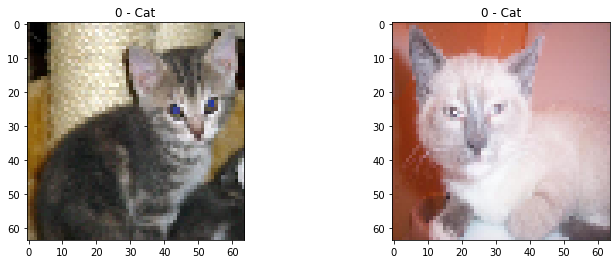

In [ ]:
title1 = "Cat" if labels[0] == 0 else "Dog"
title2 = "Cat" if labels[12500] == 0 else "Dog"

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.title("{} - {}".format(labels[0], title1))

plt.subplot(1, 2, 2)
plt.imshow(images[12500])
plt.title("{} - {}".format(labels[12500], title2))
plt.show()

In [ ]:
def best_tuners(grid_result):
    print("Highest score is {:.4f} with {} \n".format(grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    params = grid_result.cv_results_['params']
    print('List in descending order:')
    for mean, param in sorted(zip(means, params), reverse=True):
        print("{:.4f} --> {} ".format(mean, param))

## Multilayered Neural Network

In [ ]:
images_grayscaled = []

for i in tqdm(range(len(images))):
    image = tf.image.rgb_to_grayscale(images[i])
    images_grayscaled.append(image)

images_grayscaled = np.array(images_grayscaled)

  0%|          | 0/24997 [00:00<?, ?it/s]

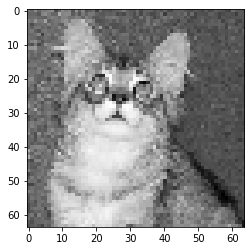

In [ ]:
plt.imshow(images_grayscaled[0][:,:,0], cmap='gray')

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
history_per_fold_mnn = []
fold_no = 1

for train, test in kfold.split(images_grayscaled, labels):
    model = tf.keras.Sequential([
    layers.Flatten(input_shape=(64, 64)),
    layers.Dense(256, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        loss=losses.BinaryCrossentropy(),
        optimizer=optimizers.SGD(learning_rate=0.001),
        metrics=['accuracy']
    )

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(images_grayscaled[train], labels[train],
                        batch_size=60,
                        epochs=30,
                        validation_data=(images_grayscaled[test], labels[test]),
                        verbose=1
                       )

    print()
    scores = model.evaluate(images_grayscaled[test], labels[test], verbose=2)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}%')
    history_per_fold_mnn.append(history)

    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
334/334 [==============================] - 7s 18ms/step - loss: 0.6949 - accuracy: 0.5222 - val_loss: 0.6884 - val_accuracy: 0.5486
Epoch 2/30
334/334 [==============================] - 4s 12ms/step - loss: 0.6839 - accuracy: 0.5596 - val_loss: 0.6824 - val_accuracy: 0.5682
Epoch 3/30
334/334 [==============================] - 4s 11ms/step - loss: 0.6788 - accuracy: 0.5718 - val_loss: 0.6835 - val_accuracy: 0.5442
Epoch 4/30
334/334 [==============================] - 4s 11ms/step - loss: 0.6750 - accuracy: 0.5782 - val_loss: 0.6753 - val_accuracy: 0.5824
Epoch 5/30
334/334 [==============================] - 4s 11ms/step - loss: 0.6723 - accuracy: 0.5873 - val_loss: 0.6732 - val_accuracy: 0.5864
Epoch 6/30
334/334 [==============================] - 4s 11ms/step - loss: 0.6695 - accuracy: 0.5935 - val_loss: 0.6734 - val_accuracy: 0.5884
Epoch 7/30
334/334 [=========================

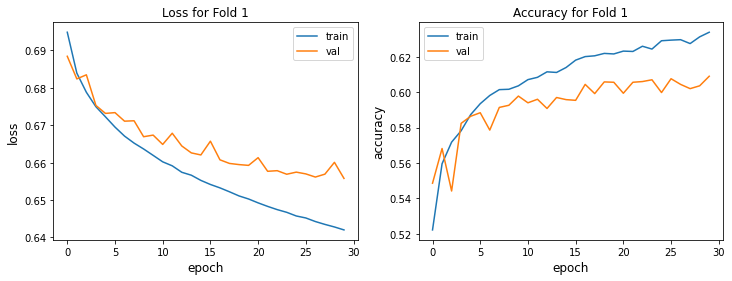

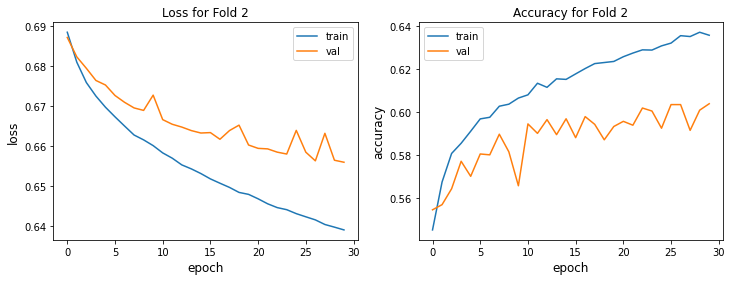

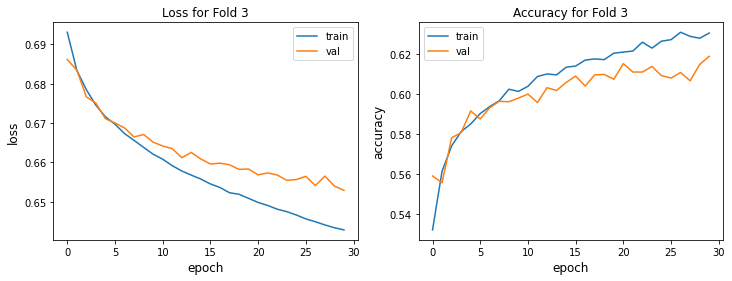

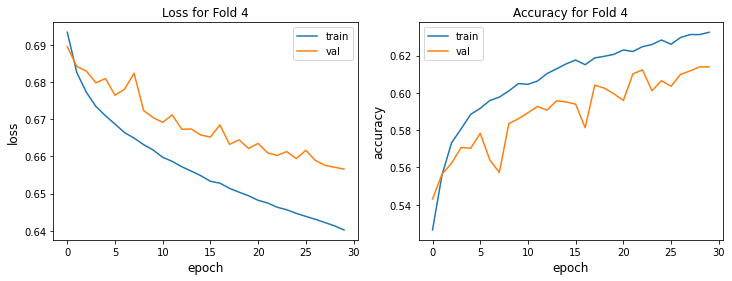

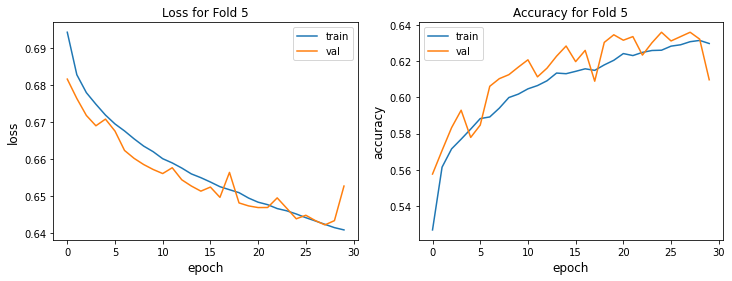

In [ ]:
for i in range(len(history_per_fold_mnn)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_per_fold_mnn[i].history['loss'])
    plt.plot(history_per_fold_mnn[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_per_fold_mnn[i].history['accuracy'])
    plt.plot(history_per_fold_mnn[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

### Hyperparameter Tuning with GridSearchCV on MLP




In [ ]:
def multilayered_model(num_of_neurons=256, activation='relu', optimizer='SGD', lr=0.001):
    
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(64, 64)),
        layers.Dense(num_of_neurons, activation=activation),
        layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

#### Tuning the number of epochs and the batch size

In this step, number of epochs and the batch size will be the variables, while the others are fixed.

In [ ]:
params = {
    'batch_size': [40,60,80],
    'epochs': [20,30,40]
}

In [ ]:
model = KerasClassifier(model=multilayered_model, verbose=2)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=3)
epoch_batch_result = grid.fit(images_grayscaled, labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/20
500/500 - 3s - loss: 0.6876 - accuracy: 0.5580 - 3s/epoch - 6ms/step
Epoch 2/20
500/500 - 3s - loss: 0.6631 - accuracy: 0.6012 - 3s/epoch - 5ms/step
Epoch 3/20
500/500 - 3s - loss: 0.6543 - accuracy: 0.6146 - 3s/epoch - 5ms/step
Epoch 4/20
500/500 - 3s - loss: 0.6482 - accuracy: 0.6226 - 3s/epoch - 5ms/step
Epoch 5/20
500/500 - 3s - loss: 0.6414 - accuracy: 0.6324 - 3s/epoch - 5ms/step
Epoch 6/20
500/500 - 3s - loss: 0.6384 - accuracy: 0.6351 - 3s/epoch - 5ms/step
Epoch 7/20
500/500 - 3s - loss: 0.6335 - accuracy: 0.6392 - 3s/epoch - 5ms/step
Epoch 8/20
500/500 - 3s - loss: 0.6296 - accuracy: 0.6457 - 3s/epoch - 5ms/step
Epoch 9/20
500/500 - 3s - loss: 0.6252 - accuracy: 0.6494 - 3s/epoch - 5ms/step
Epoch 10/20
500/500 - 3s - loss: 0.6210 - accuracy: 0.6554 - 3s/epoch - 5ms/step
Epoch 11/20
500/500 - 3s - loss: 0.6173 - accuracy: 0.6593 - 3s/epoch - 5ms/step
Epoch 12/20
500/500 - 3s - loss: 0.6128 - accuracy: 0.6640

In [ ]:
best_tuners(epoch_batch_result)

Highest score is 0.6447 with {'batch_size': 80, 'epochs': 30} 

List in descending order:
0.6447 --> {'batch_size': 80, 'epochs': 30} 
0.6385 --> {'batch_size': 40, 'epochs': 40} 
0.6350 --> {'batch_size': 40, 'epochs': 30} 
0.6338 --> {'batch_size': 80, 'epochs': 40} 
0.6334 --> {'batch_size': 60, 'epochs': 30} 
0.6309 --> {'batch_size': 60, 'epochs': 20} 
0.6308 --> {'batch_size': 40, 'epochs': 20} 
0.6297 --> {'batch_size': 80, 'epochs': 20} 
0.6125 --> {'batch_size': 60, 'epochs': 40} 


#### Tuning the optimizer and the learning rate

Now, it is time to tune the optimizer function and its learning rate. Number of epochs and batch size are fixed to the previous results.

In [ ]:
params = {
    'model__optimizer': ['SGD', 'Adam', 'Adamax'],
    'optimizer__learning_rate': [0.0001, 0.001, 0.002, 0.01]
}

In [ ]:
model = KerasClassifier(model=multilayered_model, epochs=30, batch_size=80, verbose=2)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=3)
opt_lr_result = grid.fit(images_grayscaled, labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/30
250/250 - 3s - loss: 0.6886 - accuracy: 0.5576 - 3s/epoch - 10ms/step
Epoch 2/30
250/250 - 2s - loss: 0.6678 - accuracy: 0.5897 - 2s/epoch - 8ms/step
Epoch 3/30
250/250 - 2s - loss: 0.6600 - accuracy: 0.6063 - 2s/epoch - 9ms/step
Epoch 4/30
250/250 - 2s - loss: 0.6540 - accuracy: 0.6133 - 2s/epoch - 9ms/step
Epoch 5/30
250/250 - 2s - loss: 0.6493 - accuracy: 0.6197 - 2s/epoch - 9ms/step
Epoch 6/30
250/250 - 2s - loss: 0.6452 - accuracy: 0.6262 - 2s/epoch - 9ms/step
Epoch 7/30
250/250 - 3s - loss: 0.6405 - accuracy: 0.6314 - 3s/epoch - 13ms/step
Epoch 8/30
250/250 - 3s - loss: 0.6384 - accuracy: 0.6321 - 3s/epoch - 11ms/step
Epoch 9/30
250/250 - 2s - loss: 0.6350 - accuracy: 0.6395 - 2s/epoch - 9ms/step
Epoch 10/30
250/250 - 2s - loss: 0.6306 - accuracy: 0.6412 - 2s/epoch - 9ms/step
Epoch 11/30
250/250 - 2s - loss: 0.6280 - accuracy: 0.6479 - 2s/epoch - 8ms/step
Epoch 12/30
250/250 - 2s - loss: 0.6261 - accuracy: 0.

In [ ]:
best_tuners(opt_lr_result)

Highest score is 0.6408 with {'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.0001} 

List in descending order:
0.6408 --> {'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.0001} 
0.6369 --> {'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.01} 
0.6348 --> {'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.001} 
0.6256 --> {'model__optimizer': 'Adamax', 'optimizer__learning_rate': 0.01} 
0.6244 --> {'model__optimizer': 'Adamax', 'optimizer__learning_rate': 0.002} 
0.6226 --> {'model__optimizer': 'Adamax', 'optimizer__learning_rate': 0.001} 
0.6224 --> {'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.002} 
0.6194 --> {'model__optimizer': 'Adamax', 'optimizer__learning_rate': 0.0001} 
0.6181 --> {'model__optimizer': 'Adam', 'optimizer__learning_rate': 0.01} 
0.6178 --> {'model__optimizer': 'Adam', 'optimizer__learning_rate': 0.0001} 
0.6153 --> {'model__optimizer': 'Adam', 'optimizer__learning_rate': 0.001} 
0.6090 --> {'model__optimizer': 'Adam',

#### Tuning the activation function and the number of neurons

Finally, the activation function and the number of neurons in the hidden layer will be tuned. From the lecture, we know that one hidden layer is enough to build the multilayered NN. Thus, number of hidden layers will not be tuned.

In [ ]:
params = {
    'model__activation': ['softmax', 'relu', 'tanh', 'sigmoid', 'linear'],
    'model__num_of_neurons': [64,128,256,384],
    # below are fixed
    'model__optimizer': ['SGD'],
    'optimizer__learning_rate': [0.0001]
}

In [ ]:
model = KerasClassifier(model=multilayered_model, epochs=30, batch_size=80, verbose=2)

In [ ]:
grid_2 = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=3)
activation_neurons_result_2 = grid_2.fit(images_grayscaled, labels)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Epoch 11/30
250/250 - 1s - loss: 0.6370 - accuracy: 0.6360 - 908ms/epoch - 4ms/step
Epoch 12/30
250/250 - 1s - loss: 0.6362 - accuracy: 0.6383 - 916ms/epoch - 4ms/step
Epoch 13/30
250/250 - 1s - loss: 0.6323 - accuracy: 0.6420 - 908ms/epoch - 4ms/step
Epoch 14/30
250/250 - 1s - loss: 0.6297 - accuracy: 0.6439 - 895ms/epoch - 4ms/step
Epoch 15/30
250/250 - 1s - loss: 0.6290 - accuracy: 0.6424 - 910ms/epoch - 4ms/step
Epoch 16/30
250/250 - 1s - loss: 0.6274 - accuracy: 0.6482 - 904ms/epoch - 4ms/step
Epoch 17/30
250/250 - 1s - loss: 0.6245 - accuracy: 0.6515 - 887ms/epoch - 4ms/step
Epoch 18/30
250/250 - 1s - loss: 0.6219 - accuracy: 0.6518 - 891ms/epoch - 4ms/step
Epoch 19/30
250/250 - 1s - loss: 0.6205 - accuracy: 0.6558 - 880ms/epoch - 4ms/step
Epoch 20/30
250/250 - 1s - loss: 0.6179 - accuracy: 0.6551 - 880ms/epoch - 4ms/step
Epoch 21/30
250/250 - 1s - loss: 0.6164 - accuracy: 0.6608 - 915ms/epoch - 4ms/step
Epoch 22/30
250/250 - 1s - lo

In [ ]:
best_tuners(activation_neurons_result_2)

Highest score is 0.6426 with {'model__activation': 'relu', 'model__num_of_neurons': 384, 'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.0001} 

List in descending order:
0.6426 --> {'model__activation': 'relu', 'model__num_of_neurons': 384, 'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.0001} 
0.6376 --> {'model__activation': 'relu', 'model__num_of_neurons': 256, 'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.0001} 
0.6323 --> {'model__activation': 'relu', 'model__num_of_neurons': 64, 'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.0001} 
0.6289 --> {'model__activation': 'tanh', 'model__num_of_neurons': 64, 'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.0001} 
0.6279 --> {'model__activation': 'relu', 'model__num_of_neurons': 128, 'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.0001} 
0.6245 --> {'model__activation': 'tanh', 'model__num_of_neurons': 256, 'model__optimizer': 'SGD', 'optimizer__learning_rate': 0.0001} 
0.6228 --> {

## Convolutional Neural Network



### Initial run on CNN

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 120
EPOCHS = 20

In [ ]:
fold_no = 1
history_per_fold = []

for train, test in kfold.split(images, labels):
    model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D((2, 2)), # Pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), # Pooling
    layers.Flatten(),
    layers.Dropout(0.5), # Dropout
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), # Dropout
    layers.Dense(1, activation='sigmoid')
])
    
    model.compile(
        loss=losses.BinaryCrossentropy(),
        optimizer=optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(images[train], labels[train],
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(images[test], labels[test]),
                        verbose=1
                       )

    print()
    scores = model.evaluate(images[test], labels[test], verbose=2)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    history_per_fold.append(history)

    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
167/167 [==============================] - 99s 585ms/step - loss: 0.6322 - accuracy: 0.6306 - val_loss: 0.5549 - val_accuracy: 0.7180
Epoch 2/20
167/167 [==============================] - 104s 623ms/step - loss: 0.5342 - accuracy: 0.7355 - val_loss: 0.4891 - val_accuracy: 0.7646
Epoch 3/20
167/167 [==============================] - 98s 588ms/step - loss: 0.4873 - accuracy: 0.7701 - val_loss: 0.4620 - val_accuracy: 0.7806
Epoch 4/20
167/167 [==============================] - 95s 571ms/step - loss: 0.4566 - accuracy: 0.7873 - val_loss: 0.4479 - val_accuracy: 0.7864
Epoch 5/20
167/167 [==============================] - 97s 578ms/step - loss: 0.4398 - accuracy: 0.7969 - val_loss: 0.4267 - val_accuracy: 0.7986
Epoch 6/20
167/167 [==============================] - 96s 575ms/step - loss: 0.4206 - accuracy: 0.8078 - val_loss: 0.4231 - val_accuracy: 0.8008
Epoch 7/20
167/167 [============

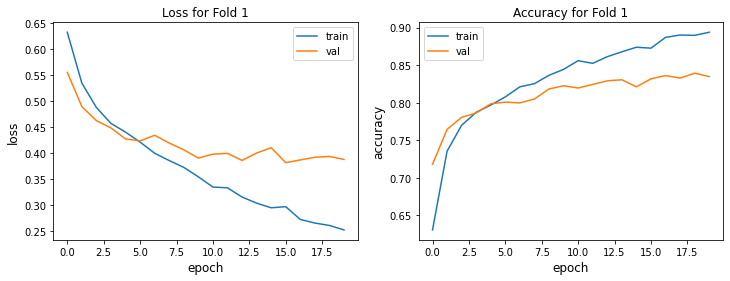

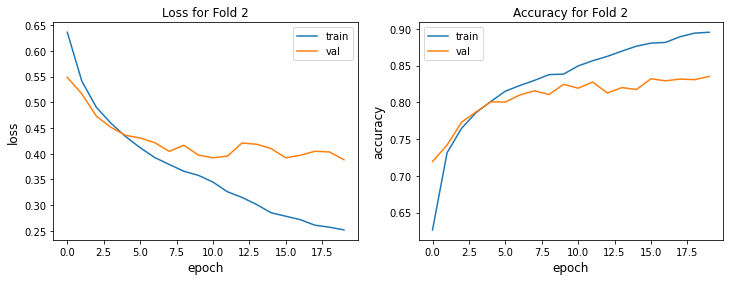

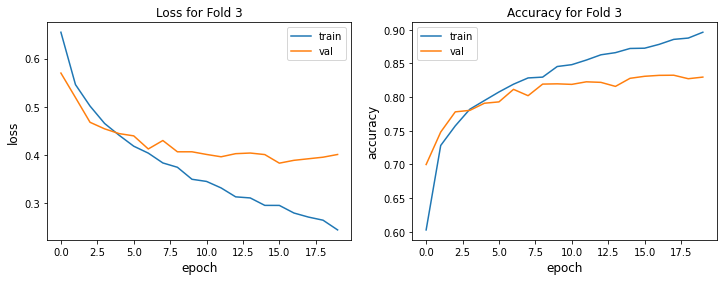

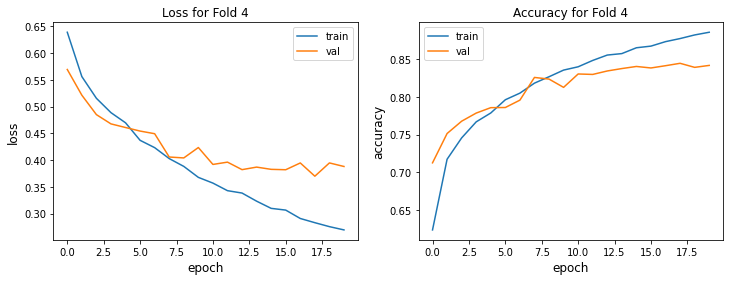

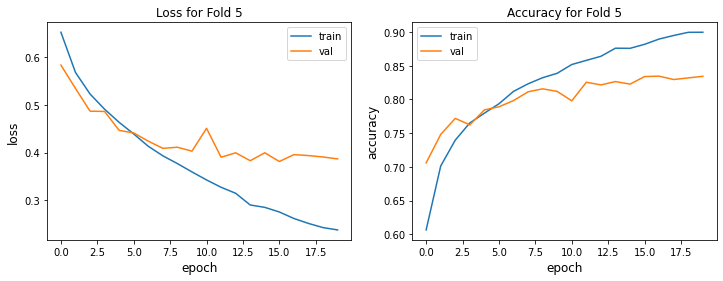

In [ ]:
for i in range(len(history_per_fold)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_per_fold[i].history['loss'])
    plt.plot(history_per_fold[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_per_fold[i].history['accuracy'])
    plt.plot(history_per_fold[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_per_fold)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/initial_histories_cnn_{}.npy'.format(i+1),history_per_fold[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/initial_fold5_model.h5")

### Hyperparameter Tuning of CNN

In [ ]:
def convolutional_model(num_of_neurons=64, activation='relu', opt="Adam", lr=0.001, dropout=0.5):

  optimizer = optimizers.Adam(learning_rate=lr)     # Adam - default
  if opt == "Adamax":
    optimizer = optimizers.Adamax(learning_rate=lr) # Adamax
  elif opt == "SGD":
    optimizer = optimizers.SGD(learning_rate=lr)    # SGD

  model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation=activation, input_shape=(64,64,3)),
    layers.MaxPooling2D((2, 2)), # Pooling
    layers.Conv2D(64, (3, 3), activation=activation),
    layers.MaxPooling2D((2, 2)), # Pooling
    layers.Flatten(),
    layers.Dropout(dropout), # Dropout
    layers.Dense(num_of_neurons, activation=activation),
    layers.Dropout(dropout), # Dropout
    layers.Dense(1, activation='sigmoid')
  ])
    
  model.compile(
      loss="binary_crossentropy",
      optimizer=optimizer,
      metrics=['accuracy']
      )
  
  return model

#### Increasing the number of epoch

Now, we increase the number of epochs to 30, and initialize the model from where we left off since the other parameters are the same. This test is mostly done to understand where the risk value will rise again and the model overfits.

In [ ]:
model = load_model("/content/drive/MyDrive/UNIMI/ML/Final Project/models/initial_fold5_model.h5")

In [ ]:
fold_no = 1
history_tuning_epoch = []

for train, test in kfold.split(images, labels):
  
  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      initial_epoch=20,
                      epochs=30,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_epoch.append(history)

  fold_no = fold_no + 1
  break

Epoch 21/30
167/167 [==============================] - 100s 598ms/step - loss: 0.2823 - accuracy: 0.8828 - val_loss: 0.2067 - val_accuracy: 0.9276
Epoch 22/30
167/167 [==============================] - 98s 588ms/step - loss: 0.2626 - accuracy: 0.8919 - val_loss: 0.2038 - val_accuracy: 0.9274
Epoch 23/30
167/167 [==============================] - 97s 580ms/step - loss: 0.2514 - accuracy: 0.8960 - val_loss: 0.2063 - val_accuracy: 0.9252
Epoch 24/30
167/167 [==============================] - 97s 581ms/step - loss: 0.2338 - accuracy: 0.9036 - val_loss: 0.2200 - val_accuracy: 0.9140
Epoch 25/30
167/167 [==============================] - 97s 579ms/step - loss: 0.2287 - accuracy: 0.9052 - val_loss: 0.2115 - val_accuracy: 0.9254
Epoch 26/30
167/167 [==============================] - 97s 579ms/step - loss: 0.2183 - accuracy: 0.9081 - val_loss: 0.2039 - val_accuracy: 0.9242
Epoch 27/30
167/167 [==============================] - 97s 581ms/step - loss: 0.2126 - accuracy: 0.9131 - val_loss: 0.2103 

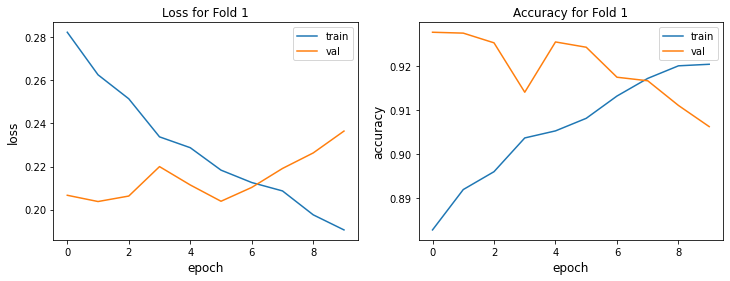

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tuning_epoch[0].history['loss'])
plt.plot(history_tuning_epoch[0].history['val_loss'])
plt.ylabel('loss', size=12)
plt.xlabel('epoch', size=12)
plt.title('Loss for Fold {}'.format(i+1))
plt.legend(['train', 'val'], fontsize=10)
    
plt.subplot(1, 2, 2)
plt.plot(history_tuning_epoch[0].history['accuracy'])
plt.plot(history_tuning_epoch[0].history['val_accuracy'])
plt.ylabel('accuracy', size=12)
plt.xlabel('epoch', size=12)
plt.title('Accuracy for Fold {}'.format(i+1))
plt.legend(['train', 'val'], fontsize=10)
plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_epoch)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_epoch_cnn_{}.npy'.format(i+1),history_tuning_epoch[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_epoch_model.h5")

#### Tuning the number of batch size

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 100
EPOCHS = 20

In [ ]:
fold_no = 1
history_tuning_batch_size = []

for train, test in kfold.split(images, labels):
  model = convolutional_model()

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_batch_size.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
200/200 [==============================] - 119s 589ms/step - loss: 0.6669 - accuracy: 0.5872 - val_loss: 0.5922 - val_accuracy: 0.6920
Epoch 2/20
200/200 [==============================] - 106s 528ms/step - loss: 0.5803 - accuracy: 0.6997 - val_loss: 0.5352 - val_accuracy: 0.7296
Epoch 3/20
200/200 [==============================] - 104s 520ms/step - loss: 0.5409 - accuracy: 0.7306 - val_loss: 0.4898 - val_accuracy: 0.7676
Epoch 4/20
200/200 [==============================] - 108s 540ms/step - loss: 0.5021 - accuracy: 0.7586 - val_loss: 0.4639 - val_accuracy: 0.7820
Epoch 5/20
200/200 [==============================] - 113s 563ms/step - loss: 0.4762 - accuracy: 0.7768 - val_loss: 0.4660 - val_accuracy: 0.7726
Epoch 6/20
200/200 [==============================] - 105s 524ms/step - loss: 0.4568 - accuracy: 0.7873 - val_loss: 0.4451 - val_accuracy: 0.7916
Epoch 7/20
200/200 [=======

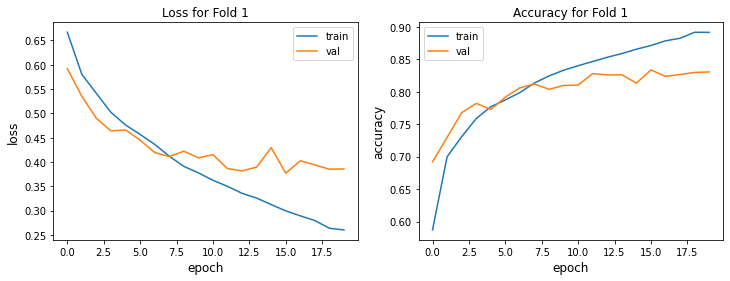

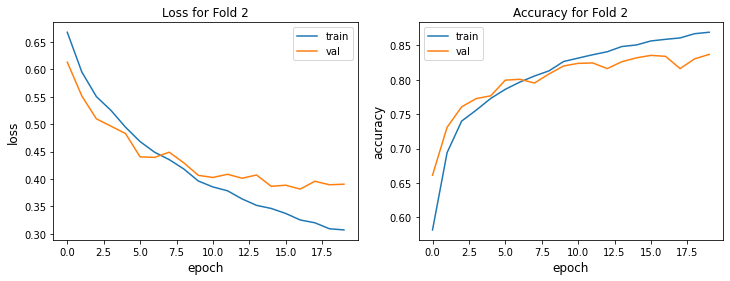

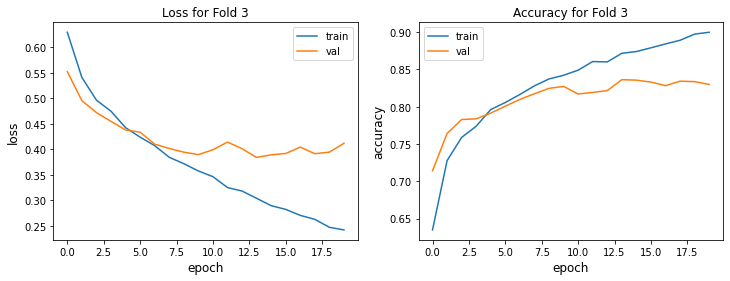

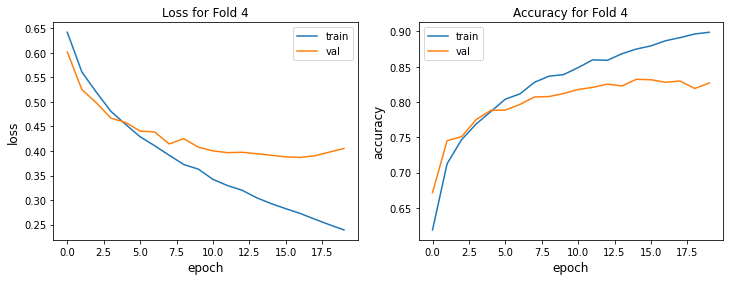

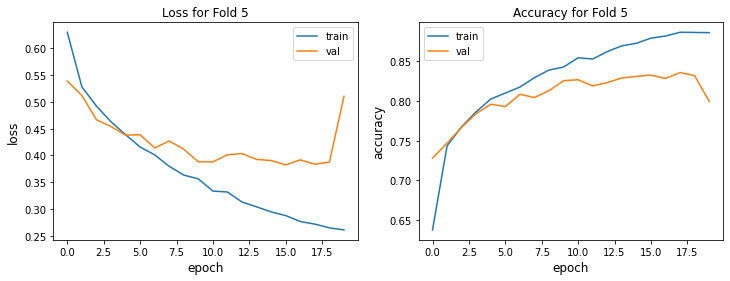

In [ ]:
for i in range(len(history_tuning_batch_size)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_batch_size[i].history['loss'])
    plt.plot(history_tuning_batch_size[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_batch_size[i].history['accuracy'])
    plt.plot(history_tuning_batch_size[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_batch_size)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_batch_size_cnn_{}.npy'.format(i+1),history_tuning_batch_size[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_batch_size_model.h5")

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 80
EPOCHS = 20

In [ ]:
fold_no = 1

for train, test in kfold.split(images, labels):
  model = convolutional_model()

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=80,
                      epochs=20,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_batch_size.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
250/250 [==============================] - 133s 527ms/step - loss: 0.6139 - accuracy: 0.6560 - val_loss: 0.5260 - val_accuracy: 0.7426
Epoch 2/20
250/250 [==============================] - 110s 442ms/step - loss: 0.5239 - accuracy: 0.7422 - val_loss: 0.4731 - val_accuracy: 0.7788
Epoch 3/20
250/250 [==============================] - 106s 423ms/step - loss: 0.4778 - accuracy: 0.7774 - val_loss: 0.4910 - val_accuracy: 0.7652
Epoch 4/20
250/250 [==============================] - 106s 423ms/step - loss: 0.4444 - accuracy: 0.7929 - val_loss: 0.4724 - val_accuracy: 0.7650
Epoch 5/20
250/250 [==============================] - 105s 421ms/step - loss: 0.4230 - accuracy: 0.8082 - val_loss: 0.4244 - val_accuracy: 0.8052
Epoch 6/20
250/250 [==============================] - 106s 424ms/step - loss: 0.4025 - accuracy: 0.8205 - val_loss: 0.4058 - val_accuracy: 0.8142
Epoch 7/20
250/250 [=======

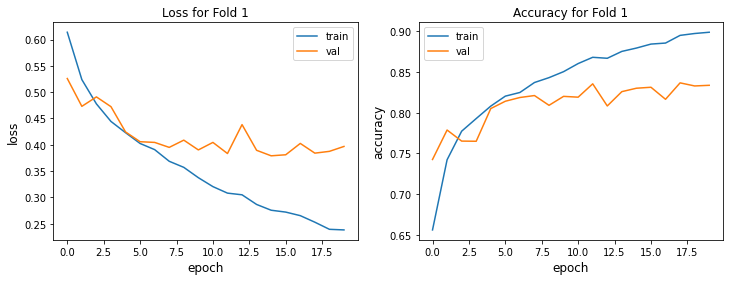

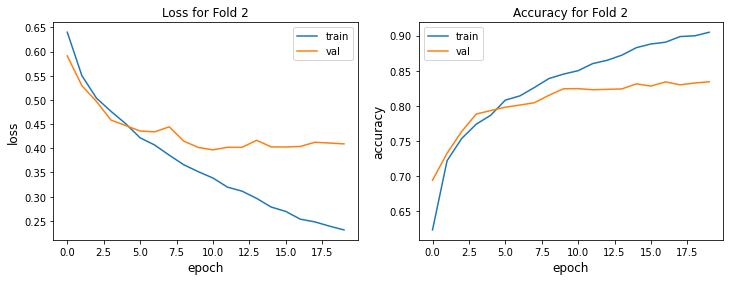

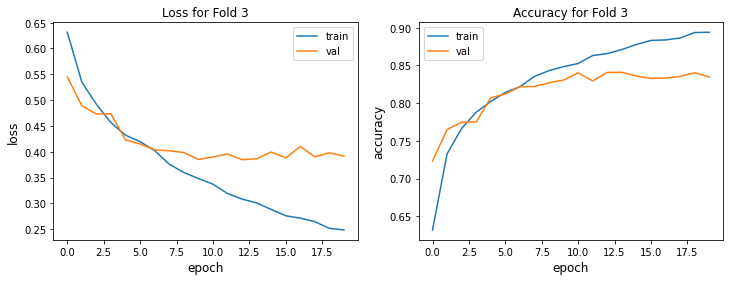

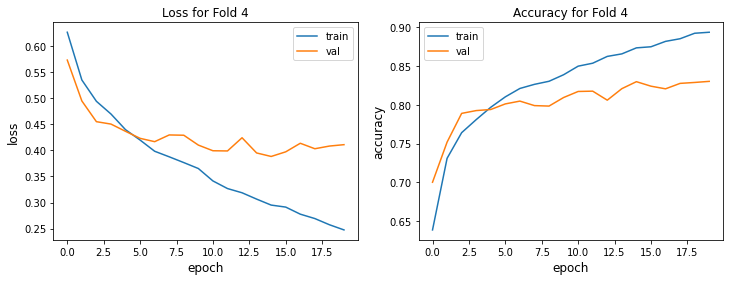

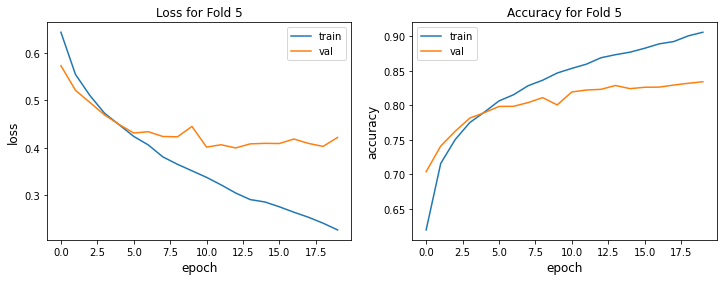

In [ ]:
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_batch_size[i+5].history['loss'])
    plt.plot(history_tuning_batch_size[i+5].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_batch_size[i+5].history['accuracy'])
    plt.plot(history_tuning_batch_size[i+5].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_batch_size)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_batch_size_cnn_{}.npy'.format(i+6),history_tuning_batch_size[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_batch_size_model_2.h5")

In [ ]:
for i in range(len(history_tuning_batch_size)):
  history_tuning_batch_size[i] = history_tuning_batch_size[i].history

In [ ]:
for i in range(5):
  history = np.load('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/initial_histories_cnn_{}.npy'.format(i+1),allow_pickle='TRUE').item()
  history_tuning_batch_size.append(history)

In [ ]:
sum_of_100 = 0
sum_of_80 = 0
sum_of_120 = 0

for i in range(len(history_tuning_batch_size)):
  if i < 5:         # batch size = 100
    sum_of_100 += history_tuning_batch_size[i]['val_accuracy'][-1]
  elif 5 <= i < 10: # batch size = 80
    sum_of_80 += history_tuning_batch_size[i]['val_accuracy'][-1]
  else:             # batch size = 120
    sum_of_120 += history_tuning_batch_size[i]['val_accuracy'][-1]

sum_of_100 /= 5
sum_of_80 /= 5
sum_of_120 /= 5

tuned_batch_size_list = {
    'batch size: 100': sum_of_100,
    'batch size: 80': sum_of_80,
    'batch size: 120': sum_of_120
}

In [ ]:
sorted(tuned_batch_size_list.items(), key=operator.itemgetter(1), reverse=True)
print('List in descending order:')
for score in sorted(tuned_batch_size_list.items(), key=operator.itemgetter(1), reverse=True):
  print('{:.4f} --> {}'.format(score[1], score[0]))

List in descending order:
0.8352 --> batch size: 120
0.8334 --> batch size: 80
0.8247 --> batch size: 100


#### Tuning the learning rate

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 120
EPOCHS = 20

In [ ]:
fold_no = 1
history_tuning_learning_rate = []

for train, test in kfold.split(images, labels):
  model = convolutional_model(lr=0.0001)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_learning_rate.append(history)

  fold_no = fold_no + 1

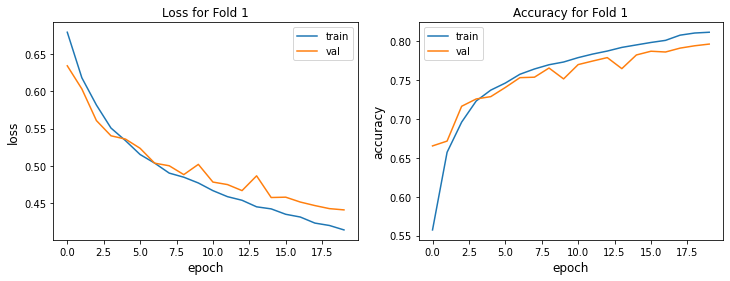

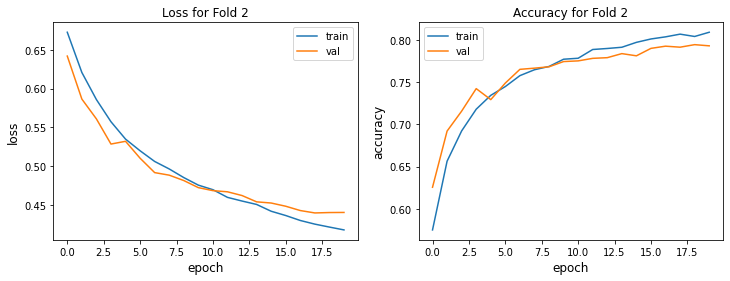

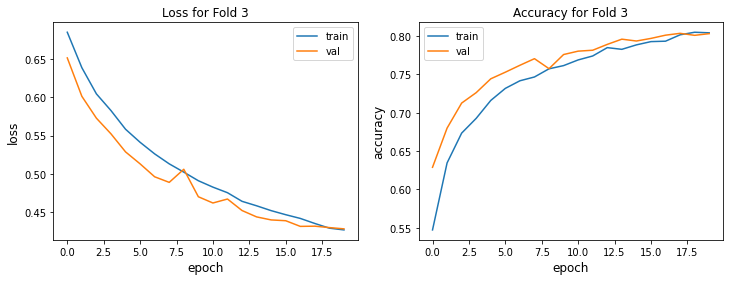

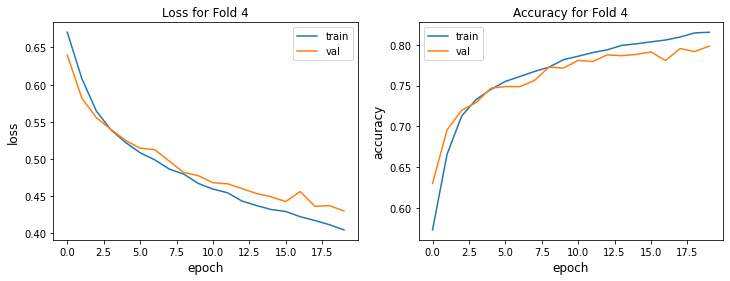

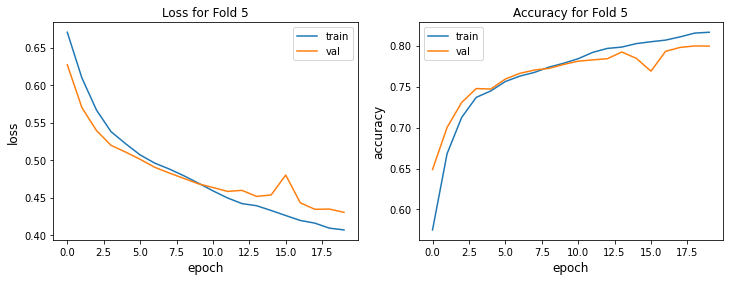

In [ ]:
for i in range(len(history_tuning_learning_rate)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_learning_rate[i].history['loss'])
    plt.plot(history_tuning_learning_rate[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_learning_rate[i].history['accuracy'])
    plt.plot(history_tuning_learning_rate[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_learning_rate)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_learning_rate_cnn_{}.npy'.format(i+1),history_tuning_learning_rate[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_learning_rate_model.h5")

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 120
EPOCHS = 20

In [ ]:
fold_no = 1

for train, test in kfold.split(images, labels):
  model = convolutional_model(lr=0.002)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_learning_rate.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
250/250 [==============================] - 106s 420ms/step - loss: 0.6306 - accuracy: 0.6379 - val_loss: 0.6161 - val_accuracy: 0.6356
Epoch 2/20
250/250 [==============================] - 104s 416ms/step - loss: 0.5515 - accuracy: 0.7178 - val_loss: 0.5181 - val_accuracy: 0.7414
Epoch 3/20
250/250 [==============================] - 104s 415ms/step - loss: 0.5063 - accuracy: 0.7559 - val_loss: 0.4967 - val_accuracy: 0.7590
Epoch 4/20
250/250 [==============================] - 108s 429ms/step - loss: 0.4749 - accuracy: 0.7761 - val_loss: 0.5078 - val_accuracy: 0.7470
Epoch 5/20
250/250 [==============================] - 102s 410ms/step - loss: 0.4482 - accuracy: 0.7905 - val_loss: 0.4615 - val_accuracy: 0.7782
Epoch 6/20
250/250 [==============================] - 103s 411ms/step - loss: 0.4302 - accuracy: 0.8011 - val_loss: 0.4667 - val_accuracy: 0.7842
Epoch 7/20
250/250 [=======

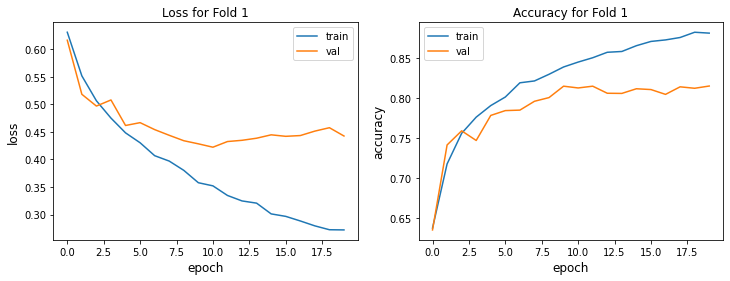

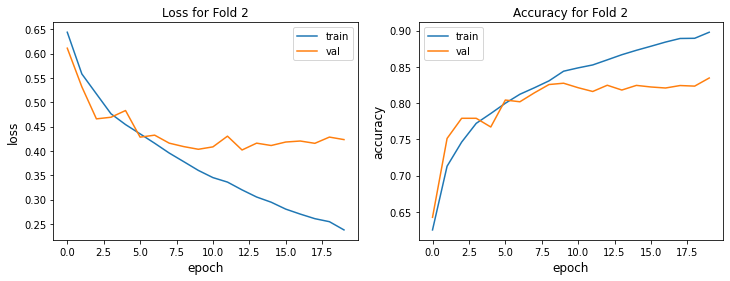

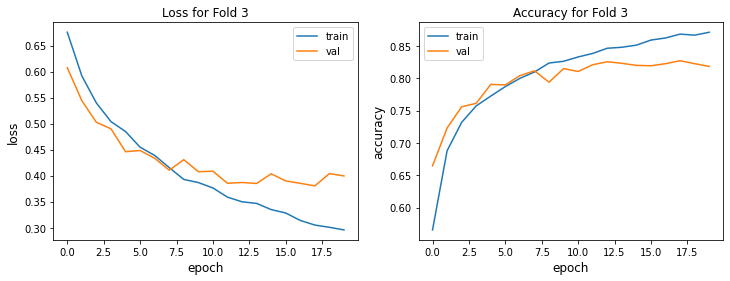

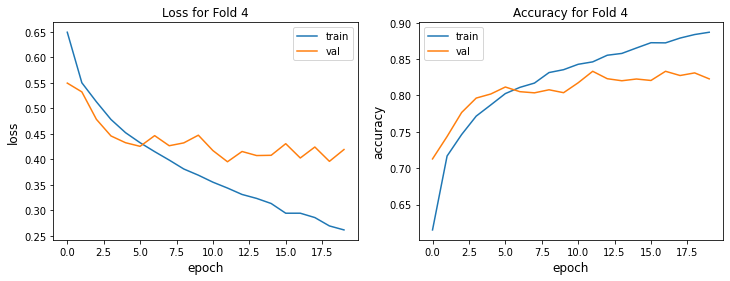

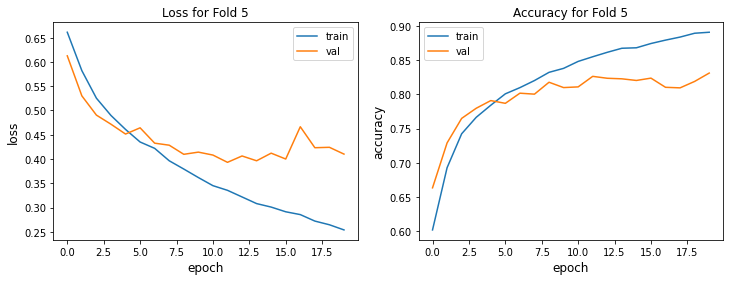

In [ ]:
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_learning_rate[i+5].history['loss'])
    plt.plot(history_tuning_learning_rate[i+5].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_learning_rate[i+5].history['accuracy'])
    plt.plot(history_tuning_learning_rate[i+5].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_learning_rate)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_learning_rate_cnn_{}.npy'.format(i+6),history_tuning_learning_rate[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_learning_rate_model_2.h5")

In [ ]:
for i in range(len(history_tuning_learning_rate)):
  history_tuning_learning_rate[i] = history_tuning_learning_rate[i].history

for i in range(5):
  history = np.load('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/initial_histories_cnn_{}.npy'.format(i+1),allow_pickle='TRUE').item()
  history_tuning_learning_rate.append(history)

In [ ]:
sum_of_002 = 0
sum_of_001 = 0
sum_of_0001 = 0

for i in range(len(history_tuning_learning_rate)):
  if i < 5:         # learning rate = 0.0001
    sum_of_0001 += history_tuning_learning_rate[i]['val_accuracy'][-1]
  elif 5 <= i < 10: # learning rate = 0.002
    sum_of_002 += history_tuning_learning_rate[i]['val_accuracy'][-1]
  else:             # learning rate = 0.001
    sum_of_001 += history_tuning_learning_rate[i]['val_accuracy'][-1]

sum_of_002 /= 5
sum_of_001 /= 5
sum_of_0001 /= 5

tuned_learning_rate_list = {
    'learning rate: 0.002': sum_of_002,
    'learning rate: 0.001': sum_of_001,
    'learning rate: 0.0001': sum_of_0001
}

In [ ]:
print('List in descending order:')
for score in sorted(tuned_learning_rate_list.items(), key=operator.itemgetter(1), reverse=True):
  print('{:.4f} --> {}'.format(score[1], score[0]))

List in descending order:
0.8352 --> learning rate: 0.001
0.8243 --> learning rate: 0.002
0.7980 --> learning rate: 0.0001


#### Re-experimenting with the number of epochs

After finding out that learning rate equal to 1e-3 acts better in terms of relationship between the training and test sets, number of epochs will be re-experimented.

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 120
EPOCHS = 30

In [ ]:
fold_no = 1
history_re_tuning_epoch_ = []

for train, test in kfold.split(images, labels):
  model = convolutional_model(lr=0.0001)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_re_tuning_epoch_.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
167/167 [==============================] - 110s 651ms/step - loss: 0.6870 - accuracy: 0.5455 - val_loss: 0.6588 - val_accuracy: 0.6118
Epoch 2/30
167/167 [==============================] - 113s 677ms/step - loss: 0.6384 - accuracy: 0.6377 - val_loss: 0.6004 - val_accuracy: 0.6918
Epoch 3/30
167/167 [==============================] - 115s 692ms/step - loss: 0.6033 - accuracy: 0.6739 - val_loss: 0.5775 - val_accuracy: 0.7092
Epoch 4/30
167/167 [==============================] - 110s 657ms/step - loss: 0.5742 - accuracy: 0.7036 - val_loss: 0.5481 - val_accuracy: 0.7320
Epoch 5/30
167/167 [==============================] - 109s 652ms/step - loss: 0.5538 - accuracy: 0.7180 - val_loss: 0.5366 - val_accuracy: 0.7340
Epoch 6/30
167/167 [==============================] - 109s 652ms/step - loss: 0.5371 - accuracy: 0.7331 - val_loss: 0.5157 - val_accuracy: 0.7542
Epoch 7/30
167/167 [=======

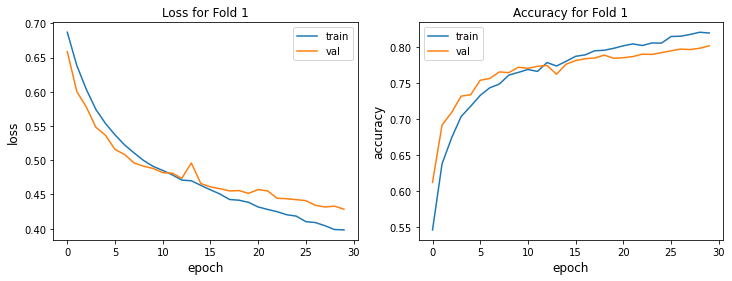

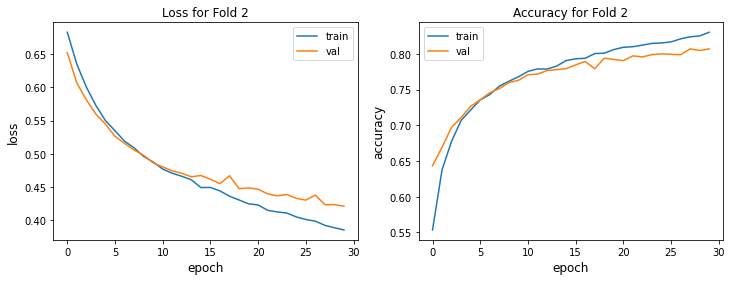

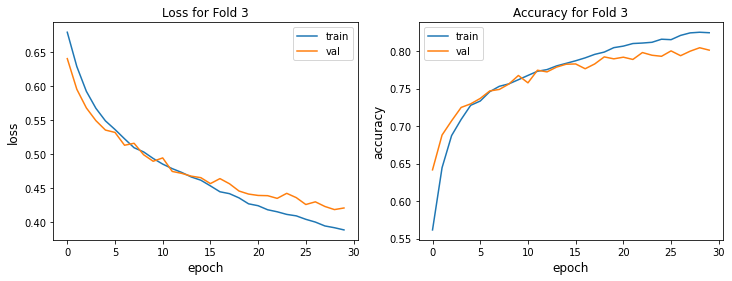

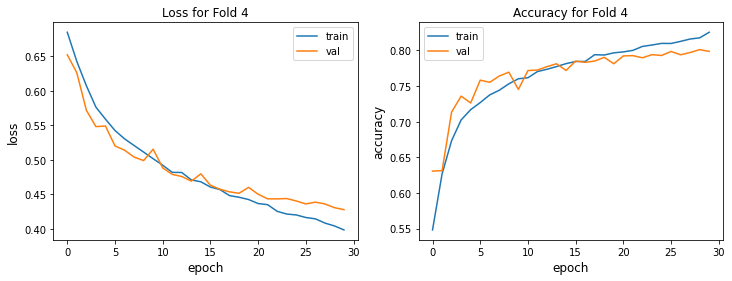

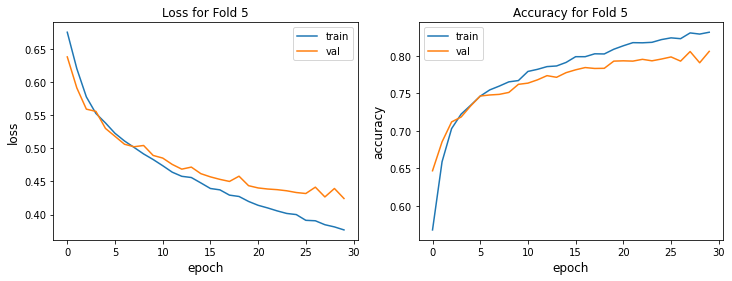

In [ ]:
for i in range(len(history_re_tuning_epoch_)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_re_tuning_epoch_[i].history['loss'])
    plt.plot(history_re_tuning_epoch_[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_re_tuning_epoch_[i].history['accuracy'])
    plt.plot(history_re_tuning_epoch_[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_re_tuning_epoch_)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/re_tuning_epoch_cnn_{}.npy'.format(i+1),history_re_tuning_epoch_[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/re_tuning_epoch_model_2.h5")

In [ ]:
for i in range(len(history_re_tuning_epoch_)):
  history_re_tuning_epoch_[i] = history_re_tuning_epoch_[i].history

In [ ]:
for i in range(5):
  history = np.load('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/initial_histories_cnn_{}.npy'.format(i+1),allow_pickle='TRUE').item()
  history_re_tuning_epoch_.append(history)

In [ ]:
sum_of_20 = 0
sum_of_30 = 0

for i in range(len(history_re_tuning_epoch_)):
  if i < 5:         # epoch = 30
    sum_of_30 += history_re_tuning_epoch_[i]['val_accuracy'][-1]
  else:             # epoch = 20
    sum_of_20 += history_re_tuning_epoch_[i]['val_accuracy'][-1]

sum_of_30 /= 5
sum_of_20 /= 5

re_tuned_epoch_list = {
    'number of epochs: 30': sum_of_30,
    'number of epochs: 20': sum_of_20
}

In [ ]:
print('List in descending order:')
for score in sorted(re_tuned_epoch_list.items(), key=operator.itemgetter(1), reverse=True):
  print('{:.4f} --> {}'.format(score[1], score[0]))

List in descending order:
0.8352 --> number of epochs: 20
0.8031 --> number of epochs: 30


#### Tuning the optimizer

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 120
EPOCHS = 20

In [ ]:
fold_no = 1
history_tuning_optimizer = []

for train, test in kfold.split(images, labels):
  model = convolutional_model(opt="SGD", lr=0.001)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_optimizer.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
167/167 [==============================] - 115s 681ms/step - loss: 0.7000 - accuracy: 0.4966 - val_loss: 0.6927 - val_accuracy: 0.5176
Epoch 2/20
167/167 [==============================] - 113s 677ms/step - loss: 0.6969 - accuracy: 0.5006 - val_loss: 0.6920 - val_accuracy: 0.5362
Epoch 3/20
167/167 [==============================] - 113s 679ms/step - loss: 0.6960 - accuracy: 0.5053 - val_loss: 0.6913 - val_accuracy: 0.5522
Epoch 4/20
167/167 [==============================] - 113s 677ms/step - loss: 0.6938 - accuracy: 0.5113 - val_loss: 0.6907 - val_accuracy: 0.5640
Epoch 5/20
167/167 [==============================] - 114s 681ms/step - loss: 0.6937 - accuracy: 0.5079 - val_loss: 0.6903 - val_accuracy: 0.5718
Epoch 6/20
167/167 [==============================] - 116s 694ms/step - loss: 0.6926 - accuracy: 0.5169 - val_loss: 0.6899 - val_accuracy: 0.5776
Epoch 7/20
167/167 [=======

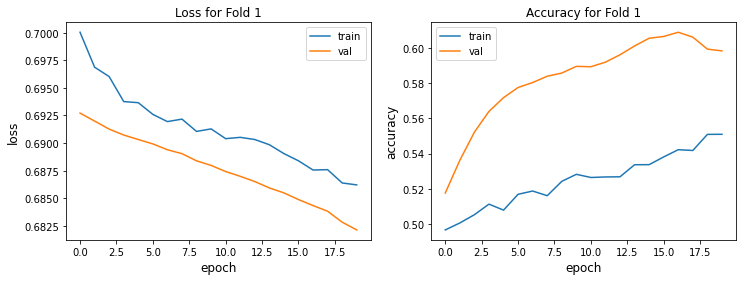

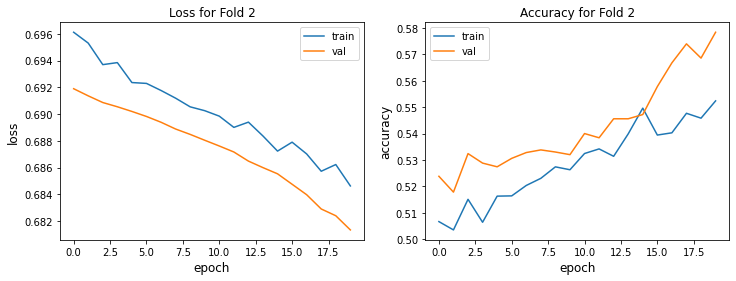

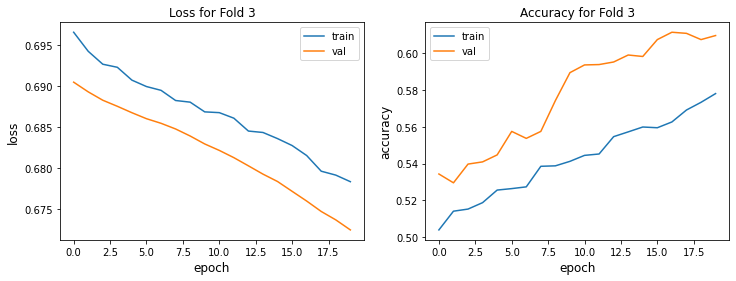

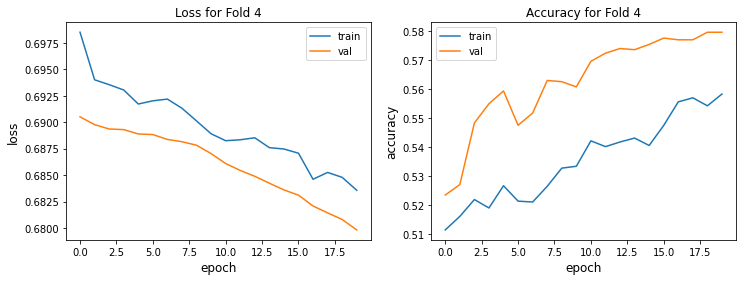

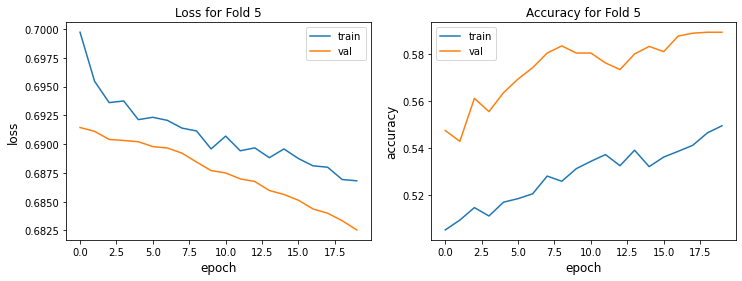

In [ ]:
for i in range(len(history_tuning_optimizer)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_optimizer[i].history['loss'])
    plt.plot(history_tuning_optimizer[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_optimizer[i].history['accuracy'])
    plt.plot(history_tuning_optimizer[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_optimizer)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_optimizer_cnn_{}.npy'.format(i+1),history_tuning_optimizer[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_optimizer_model.h5")

In [ ]:
fold_no = 1

for train, test in kfold.split(images, labels):
  model = convolutional_model(opt="Adamax", lr=0.001)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_optimizer.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
167/167 [==============================] - 109s 645ms/step - loss: 0.6612 - accuracy: 0.5946 - val_loss: 0.6117 - val_accuracy: 0.6774
Epoch 2/20
167/167 [==============================] - 107s 642ms/step - loss: 0.5926 - accuracy: 0.6883 - val_loss: 0.5580 - val_accuracy: 0.7236
Epoch 3/20
167/167 [==============================] - 107s 641ms/step - loss: 0.5524 - accuracy: 0.7242 - val_loss: 0.5263 - val_accuracy: 0.7396
Epoch 4/20
167/167 [==============================] - 110s 661ms/step - loss: 0.5319 - accuracy: 0.7368 - val_loss: 0.5075 - val_accuracy: 0.7500
Epoch 5/20
167/167 [==============================] - 107s 643ms/step - loss: 0.5079 - accuracy: 0.7556 - val_loss: 0.4878 - val_accuracy: 0.7644
Epoch 6/20
167/167 [==============================] - 107s 642ms/step - loss: 0.4955 - accuracy: 0.7613 - val_loss: 0.4820 - val_accuracy: 0.7634
Epoch 7/20
167/167 [=======

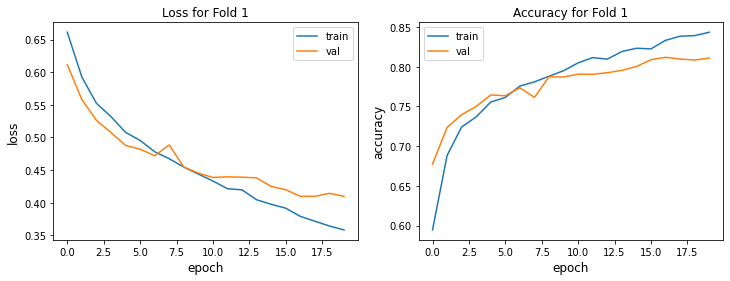

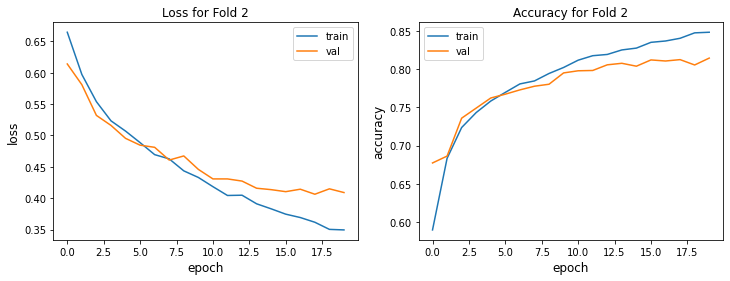

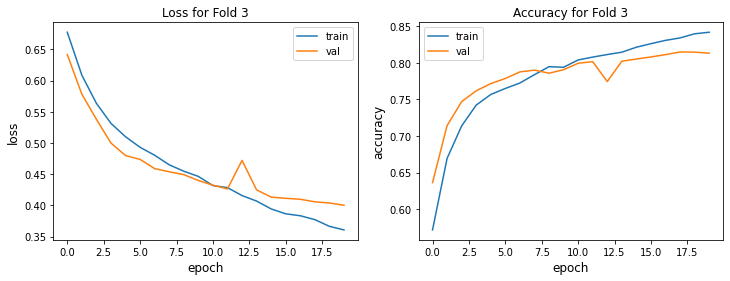

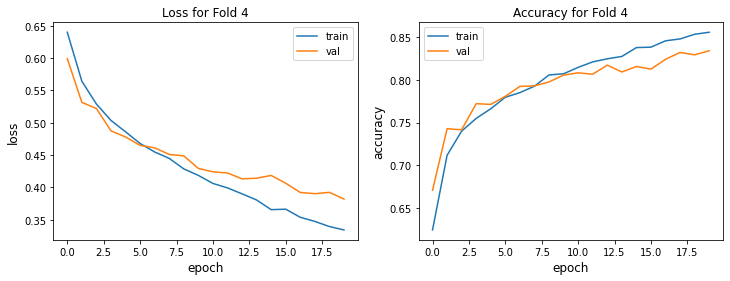

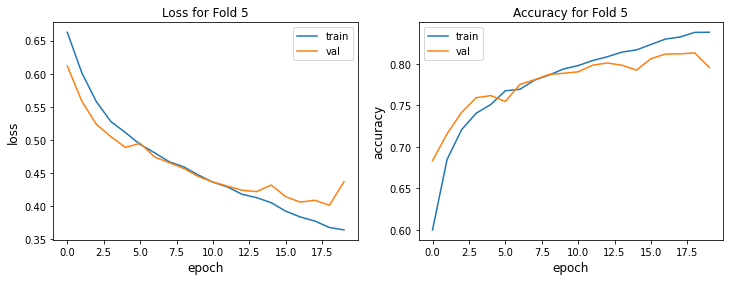

In [ ]:
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_optimizer[i+5].history['loss'])
    plt.plot(history_tuning_optimizer[i+5].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_optimizer[i+5].history['accuracy'])
    plt.plot(history_tuning_optimizer[i+5].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_optimizer)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_optimizer_cnn_{}.npy'.format(i+6),history_tuning_optimizer[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_optimizer_model_2.h5")

In [ ]:
for i in range(len(history_tuning_optimizer)):
  history_tuning_optimizer[i] = history_tuning_optimizer[i].history

for i in range(5):
  history = np.load('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/initial_histories_cnn_{}.npy'.format(i+1),allow_pickle='TRUE').item()
  history_tuning_optimizer.append(history)

In [ ]:
sum_of_Adam = 0
sum_of_SGD = 0
sum_of_Adamax = 0

for i in range(len(history_tuning_optimizer)):
  if i < 5:         # optimizer = SGD
    sum_of_SGD += history_tuning_optimizer[i]['val_accuracy'][-1]
  elif 5 <= i < 10: # optimizer = Adamax
    sum_of_Adamax += history_tuning_optimizer[i]['val_accuracy'][-1]
  else:             # optimizer = Adam
    sum_of_Adam += history_tuning_optimizer[i]['val_accuracy'][-1]

sum_of_Adam /= 5
sum_of_SGD /= 5
sum_of_Adamax /= 5

tuned_optimizer_list = {
    'optimizer: Adam': sum_of_Adam,
    'optimizer: SGD': sum_of_SGD,
    'optimizer: Adamax': sum_of_Adamax
}

In [ ]:
print('List in descending order:')
for score in sorted(tuned_optimizer_list.items(), key=operator.itemgetter(1), reverse=True):
  print('{:.4f} --> {}'.format(score[1], score[0]))

List in descending order:
0.8352 --> optimizer: Adam
0.8136 --> optimizer: Adamax
0.5910 --> optimizer: SGD


#### Tuning the activation function

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 120
EPOCHS = 20

In [ ]:
fold_no = 1
history_tuning_activation = []

for train, test in kfold.split(images, labels):
  model = convolutional_model(activation='tanh')

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_activation.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
167/167 [==============================] - 121s 713ms/step - loss: 0.6389 - accuracy: 0.6581 - val_loss: 0.5533 - val_accuracy: 0.7198
Epoch 2/20
167/167 [==============================] - 123s 736ms/step - loss: 0.5338 - accuracy: 0.7368 - val_loss: 0.5108 - val_accuracy: 0.7512
Epoch 3/20
167/167 [==============================] - 121s 727ms/step - loss: 0.5070 - accuracy: 0.7535 - val_loss: 0.5040 - val_accuracy: 0.7596
Epoch 4/20
167/167 [==============================] - 119s 715ms/step - loss: 0.4910 - accuracy: 0.7610 - val_loss: 0.5005 - val_accuracy: 0.7532
Epoch 5/20
167/167 [==============================] - 121s 726ms/step - loss: 0.4723 - accuracy: 0.7749 - val_loss: 0.4887 - val_accuracy: 0.7676
Epoch 6/20
167/167 [==============================] - 119s 714ms/step - loss: 0.4628 - accuracy: 0.7816 - val_loss: 0.4883 - val_accuracy: 0.7706
Epoch 7/20
167/167 [=======

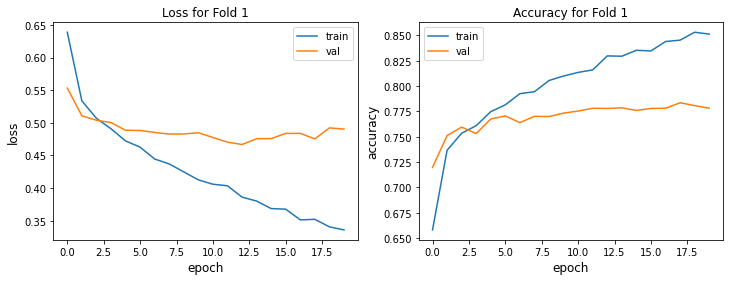

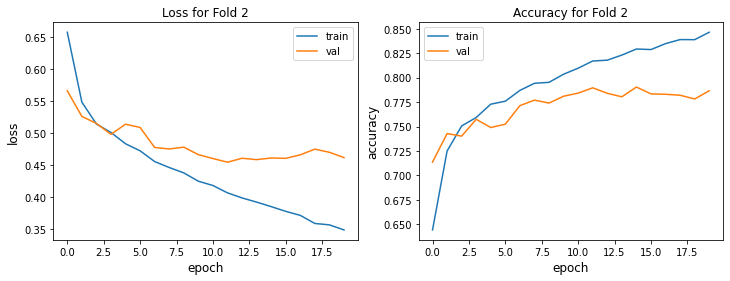

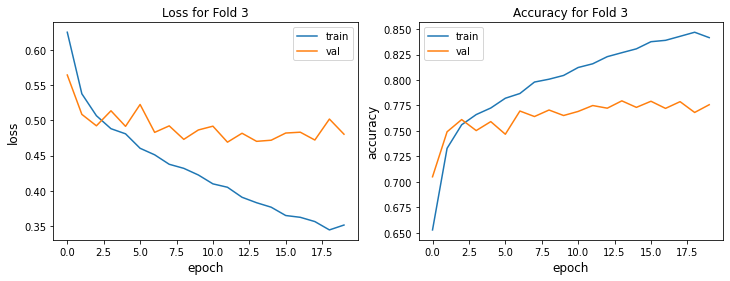

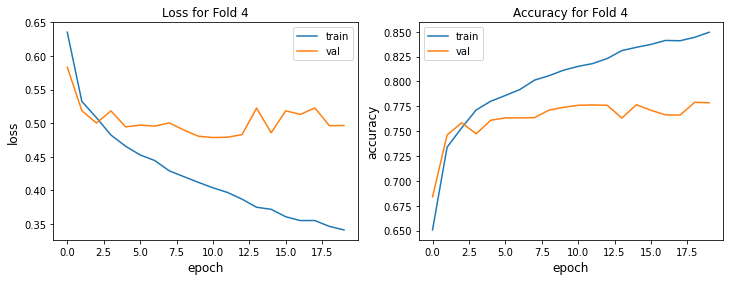

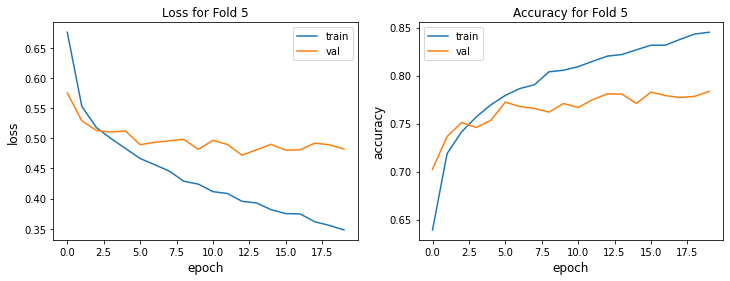

In [ ]:
for i in range(len(history_tuning_activation)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_activation[i].history['loss'])
    plt.plot(history_tuning_activation[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_activation[i].history['accuracy'])
    plt.plot(history_tuning_activation[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_activation)):
  np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_activation_cnn_{}.npy'.format(i+1),history_tuning_activation[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_activation_model.h5")

In [ ]:
fold_no = 1

for train, test in kfold.split(images, labels):
  model = convolutional_model(activation='sigmoid')

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_activation.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
167/167 [==============================] - 114s 672ms/step - loss: 0.7556 - accuracy: 0.5002 - val_loss: 0.6934 - val_accuracy: 0.5026
Epoch 2/20
167/167 [==============================] - 111s 663ms/step - loss: 0.7194 - accuracy: 0.5020 - val_loss: 0.6934 - val_accuracy: 0.5026
Epoch 3/20
167/167 [==============================] - 116s 695ms/step - loss: 0.7046 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 4/20
167/167 [==============================] - 110s 656ms/step - loss: 0.6963 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.5026
Epoch 5/20
167/167 [==============================] - 110s 657ms/step - loss: 0.6946 - accuracy: 0.5020 - val_loss: 0.6935 - val_accuracy: 0.5026
Epoch 6/20
167/167 [==============================] - 110s 660ms/step - loss: 0.6942 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 7/20
167/167 [=======

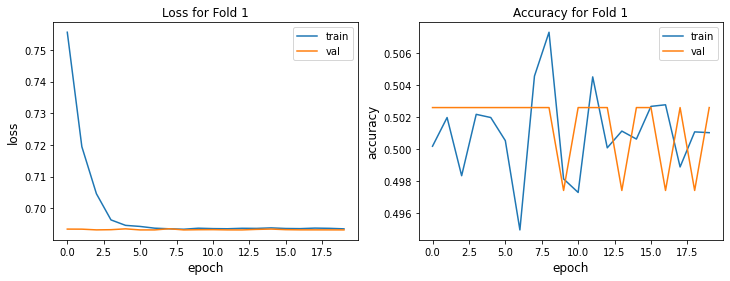

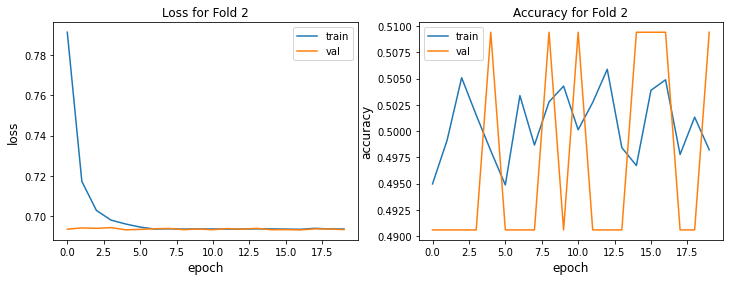

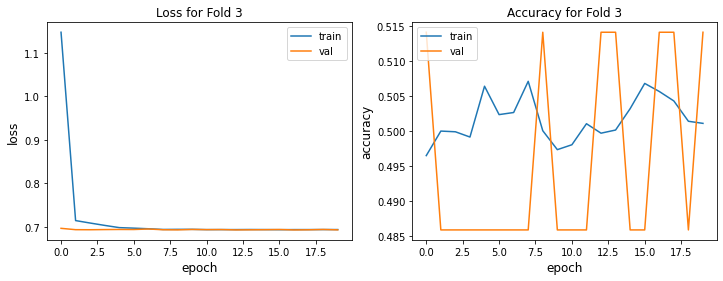

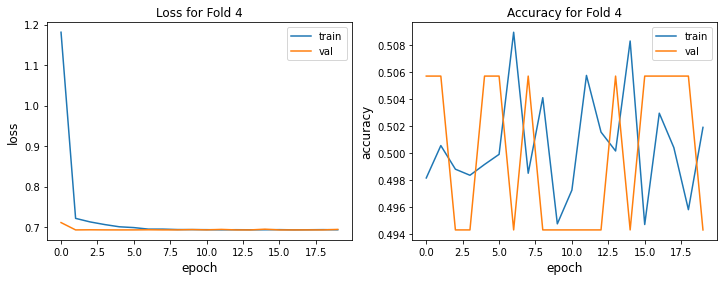

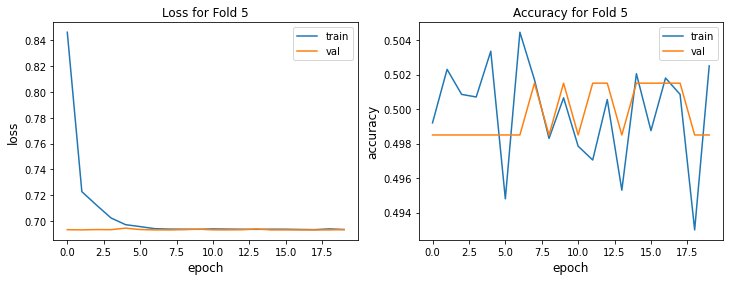

In [ ]:
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_activation[i+5].history['loss'])
    plt.plot(history_tuning_activation[i+5].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_activation[i+5].history['accuracy'])
    plt.plot(history_tuning_activation[i+5].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_activation)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_activation_cnn_{}.npy'.format(i+6),history_tuning_activation[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_activation_model_2.h5")

In [ ]:
for i in range(len(history_tuning_activation)):
  history_tuning_activation[i] = history_tuning_activation[i].history

for i in range(5):
  history = np.load('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/initial_histories_cnn_{}.npy'.format(i+1),allow_pickle='TRUE').item()
  history_tuning_activation.append(history)

In [ ]:
sum_of_relu = 0
sum_of_tanh = 0
sum_of_sigmoid = 0

for i in range(len(history_tuning_activation)):
  if i < 5:         # activation = tanh
    sum_of_tanh += history_tuning_activation[i]['val_accuracy'][-1]
  elif 5 <= i < 10: # activation = sigmoid
    sum_of_sigmoid += history_tuning_activation[i]['val_accuracy'][-1]
  else:             # activation = relu
    sum_of_relu += history_tuning_activation[i]['val_accuracy'][-1]

sum_of_relu /= 5
sum_of_tanh /= 5
sum_of_sigmoid /= 5

tuned_activation_list = {
    'activation: ReLU': sum_of_relu,
    'activation: tanh': sum_of_tanh,
    'activation: sigmoid': sum_of_sigmoid
}

In [ ]:
print('List in descending order:')
for score in sorted(tuned_activation_list.items(), key=operator.itemgetter(1), reverse=True):
  print('{:.4f} --> {}'.format(score[1], score[0]))

List in descending order:
0.8352 --> activation: ReLU
0.7805 --> activation: tanh
0.5038 --> activation: sigmoid


#### Tuning the number of neurons

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 120
EPOCHS = 20

In [ ]:
fold_no = 1
history_tuning_neurons = []

for train, test in kfold.split(images, labels):
  model = convolutional_model(num_of_neurons=128)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_neurons.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
167/167 [==============================] - 17s 21ms/step - loss: 0.6277 - accuracy: 0.6326 - val_loss: 0.5486 - val_accuracy: 0.7160
Epoch 2/20
167/167 [==============================] - 3s 17ms/step - loss: 0.5385 - accuracy: 0.7266 - val_loss: 0.5199 - val_accuracy: 0.7438
Epoch 3/20
167/167 [==============================] - 3s 17ms/step - loss: 0.4842 - accuracy: 0.7677 - val_loss: 0.4578 - val_accuracy: 0.7856
Epoch 4/20
167/167 [==============================] - 3s 17ms/step - loss: 0.4510 - accuracy: 0.7858 - val_loss: 0.4415 - val_accuracy: 0.7944
Epoch 5/20
167/167 [==============================] - 3s 17ms/step - loss: 0.4162 - accuracy: 0.8078 - val_loss: 0.4194 - val_accuracy: 0.8058
Epoch 6/20
167/167 [==============================] - 3s 17ms/step - loss: 0.3980 - accuracy: 0.8185 - val_loss: 0.4420 - val_accuracy: 0.7924
Epoch 7/20
167/167 [========================

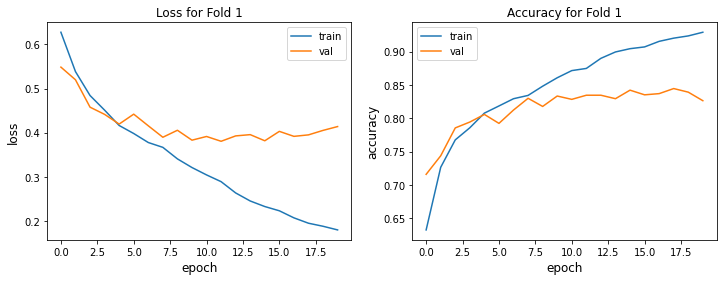

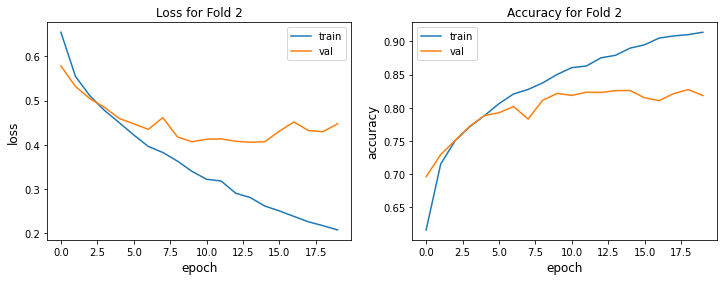

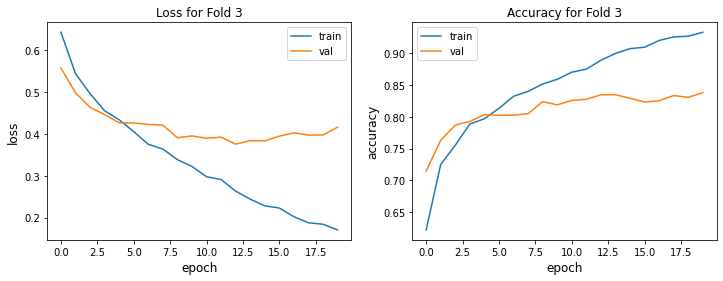

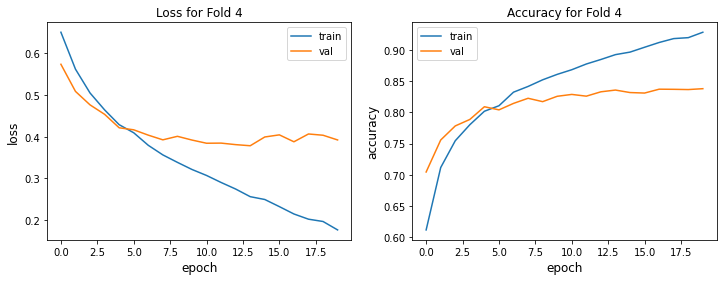

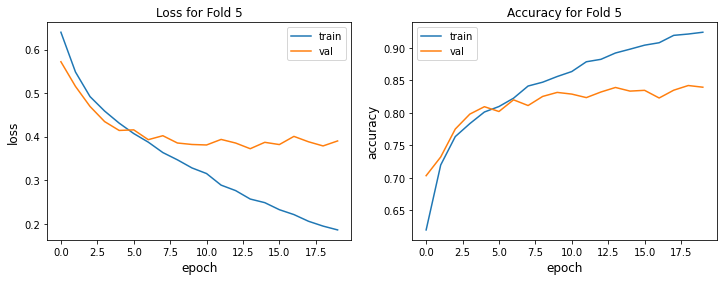

In [ ]:
for i in range(len(history_tuning_neurons)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_neurons[i].history['loss'])
    plt.plot(history_tuning_neurons[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_neurons[i].history['accuracy'])
    plt.plot(history_tuning_neurons[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_neurons)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_neurons_cnn_{}.npy'.format(i+1),history_tuning_neurons[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_neurons_model.h5")

In [ ]:
fold_no = 1

for train, test in kfold.split(images, labels):
  model = convolutional_model(num_of_neurons=48)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_neurons.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
167/167 [==============================] - 15s 20ms/step - loss: 0.6546 - accuracy: 0.6040 - val_loss: 0.5712 - val_accuracy: 0.7030
Epoch 2/20
167/167 [==============================] - 3s 16ms/step - loss: 0.5613 - accuracy: 0.7121 - val_loss: 0.4974 - val_accuracy: 0.7556
Epoch 3/20
167/167 [==============================] - 3s 16ms/step - loss: 0.5171 - accuracy: 0.7457 - val_loss: 0.4906 - val_accuracy: 0.7592
Epoch 4/20
167/167 [==============================] - 3s 16ms/step - loss: 0.4854 - accuracy: 0.7707 - val_loss: 0.4633 - val_accuracy: 0.7882
Epoch 5/20
167/167 [==============================] - 3s 16ms/step - loss: 0.4585 - accuracy: 0.7815 - val_loss: 0.4374 - val_accuracy: 0.7872
Epoch 6/20
167/167 [==============================] - 3s 16ms/step - loss: 0.4385 - accuracy: 0.7993 - val_loss: 0.4396 - val_accuracy: 0.7896
Epoch 7/20
167/167 [========================

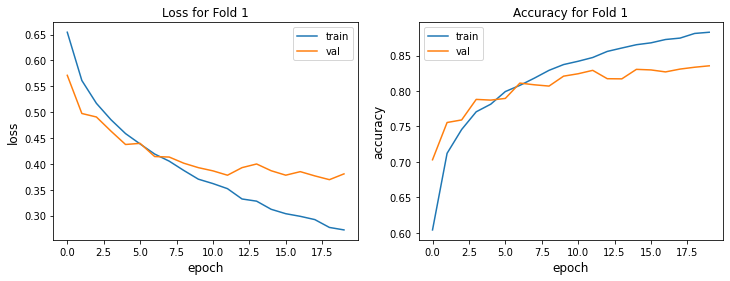

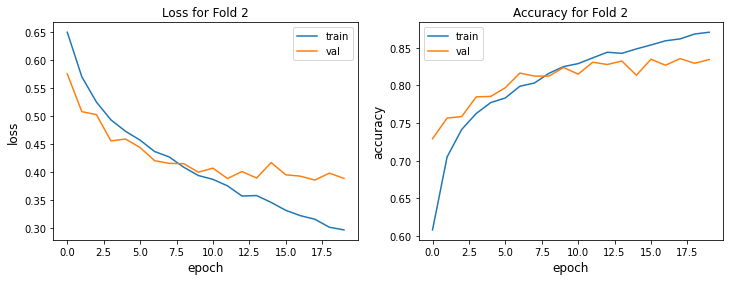

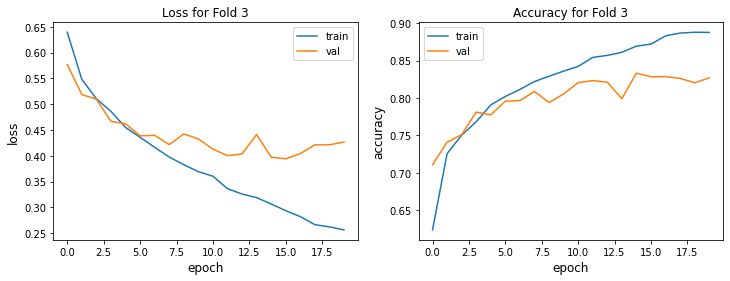

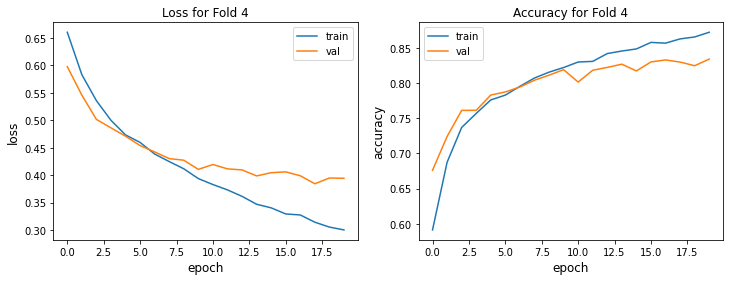

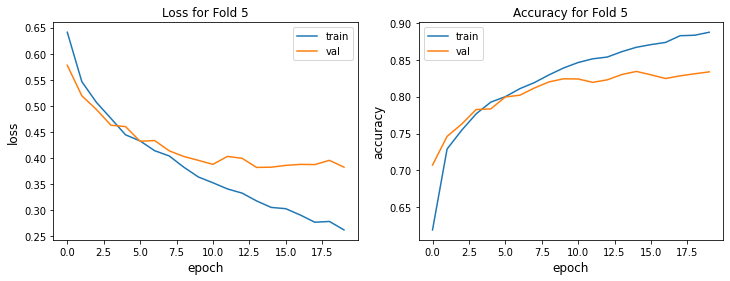

In [ ]:
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_neurons[i+5].history['loss'])
    plt.plot(history_tuning_neurons[i+5].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_neurons[i+5].history['accuracy'])
    plt.plot(history_tuning_neurons[i+5].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_neurons)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_neurons_cnn_{}.npy'.format(i+6),history_tuning_neurons[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_neurons_model_2.h5")

In [ ]:
for i in range(len(history_tuning_neurons)):
  history_tuning_neurons[i] = history_tuning_neurons[i].history

for i in range(5):
  history = np.load('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/initial_histories_cnn_{}.npy'.format(i+1),allow_pickle='TRUE').item()
  history_tuning_neurons.append(history)

In [ ]:
sum_of_64 = 0
sum_of_48 = 0
sum_of_128 = 0

for i in range(len(history_tuning_neurons)):
  if i < 5:         # neurons = 128
    sum_of_128 += history_tuning_neurons[i]['val_accuracy'][-1]
  elif 5 <= i < 10: # neurons = 48
    sum_of_48 += history_tuning_neurons[i]['val_accuracy'][-1]
  else:             # neurons = 64
    sum_of_64 += history_tuning_neurons[i]['val_accuracy'][-1]

sum_of_64 /= 5
sum_of_48 /= 5
sum_of_128 /= 5

tuned_neurons_list = {
    'neurons: 128': sum_of_128,
    'neurons: 48': sum_of_48,
    'neurons: 64': sum_of_64
}

In [ ]:
print('List in descending order:')
for score in sorted(tuned_neurons_list.items(), key=operator.itemgetter(1), reverse=True):
  print('{:.4f} --> {}'.format(score[1], score[0]))

List in descending order:
0.8352 --> neurons: 64
0.8328 --> neurons: 48
0.8321 --> neurons: 128


#### Tuning the dropout

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 120
EPOCHS = 20

In [ ]:
fold_no = 1
history_tuning_dropout = []

for train, test in kfold.split(images, labels):
  model = convolutional_model(dropout=0.2)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_dropout.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
167/167 [==============================] - 14s 20ms/step - loss: 0.6400 - accuracy: 0.6170 - val_loss: 0.5474 - val_accuracy: 0.7202
Epoch 2/20
167/167 [==============================] - 3s 16ms/step - loss: 0.5332 - accuracy: 0.7321 - val_loss: 0.5144 - val_accuracy: 0.7462
Epoch 3/20
167/167 [==============================] - 3s 16ms/step - loss: 0.4843 - accuracy: 0.7663 - val_loss: 0.4713 - val_accuracy: 0.7722
Epoch 4/20
167/167 [==============================] - 3s 16ms/step - loss: 0.4562 - accuracy: 0.7856 - val_loss: 0.4538 - val_accuracy: 0.7846
Epoch 5/20
167/167 [==============================] - 3s 16ms/step - loss: 0.4203 - accuracy: 0.8080 - val_loss: 0.4407 - val_accuracy: 0.7922
Epoch 6/20
167/167 [==============================] - 3s 17ms/step - loss: 0.3877 - accuracy: 0.8264 - val_loss: 0.4384 - val_accuracy: 0.7952
Epoch 7/20
167/167 [========================

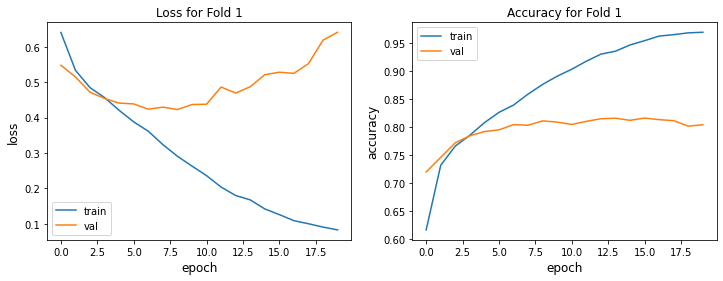

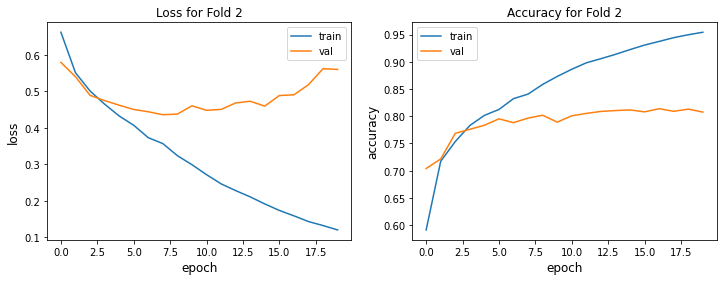

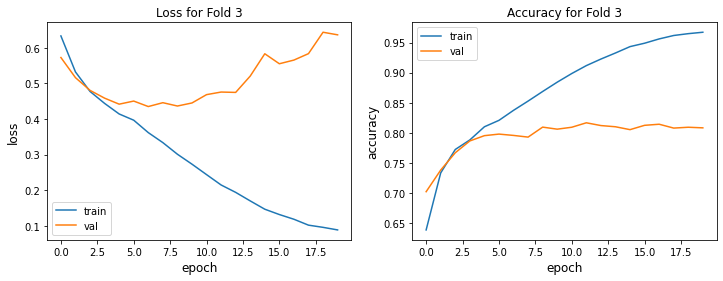

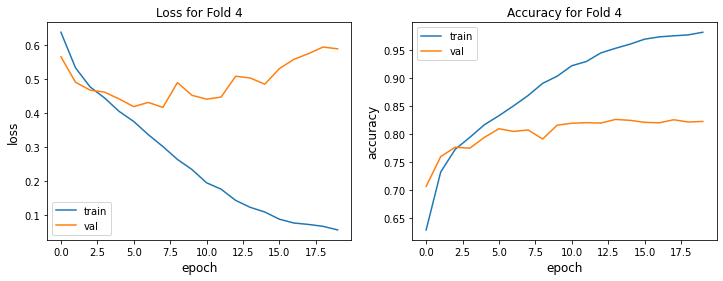

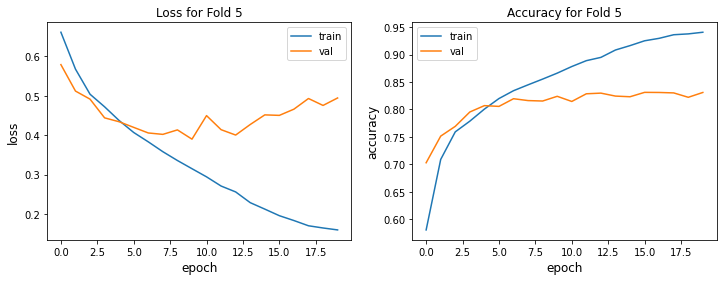

In [ ]:
for i in range(len(history_tuning_dropout)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_dropout[i].history['loss'])
    plt.plot(history_tuning_dropout[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_dropout[i].history['accuracy'])
    plt.plot(history_tuning_dropout[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_dropout)):
  np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_dropout_cnn_{}.npy'.format(i+1),history_tuning_dropout[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_dropout_model.h5")

In [ ]:
fold_no = 1

for train, test in kfold.split(images, labels):
  model = convolutional_model(dropout=0.8)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_tuning_dropout.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
167/167 [==============================] - 16s 22ms/step - loss: 0.6796 - accuracy: 0.5545 - val_loss: 0.6180 - val_accuracy: 0.6880
Epoch 2/20
167/167 [==============================] - 3s 17ms/step - loss: 0.6137 - accuracy: 0.6653 - val_loss: 0.5756 - val_accuracy: 0.6920
Epoch 3/20
167/167 [==============================] - 3s 17ms/step - loss: 0.5749 - accuracy: 0.7025 - val_loss: 0.5209 - val_accuracy: 0.7458
Epoch 4/20
167/167 [==============================] - 3s 18ms/step - loss: 0.5489 - accuracy: 0.7267 - val_loss: 0.5008 - val_accuracy: 0.7568
Epoch 5/20
167/167 [==============================] - 3s 19ms/step - loss: 0.5314 - accuracy: 0.7387 - val_loss: 0.4839 - val_accuracy: 0.7822
Epoch 6/20
167/167 [==============================] - 3s 17ms/step - loss: 0.5161 - accuracy: 0.7486 - val_loss: 0.4862 - val_accuracy: 0.7742
Epoch 7/20
167/167 [========================

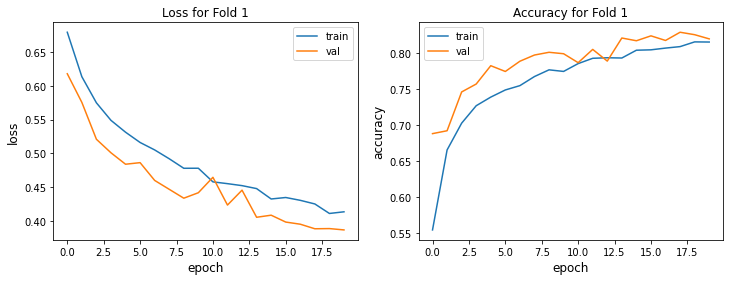

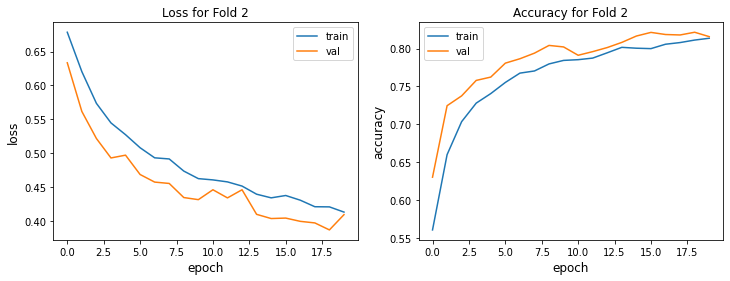

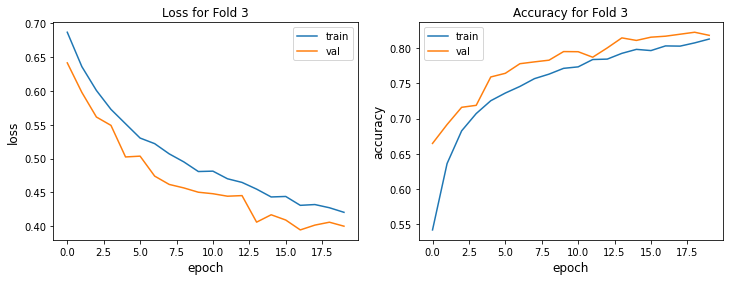

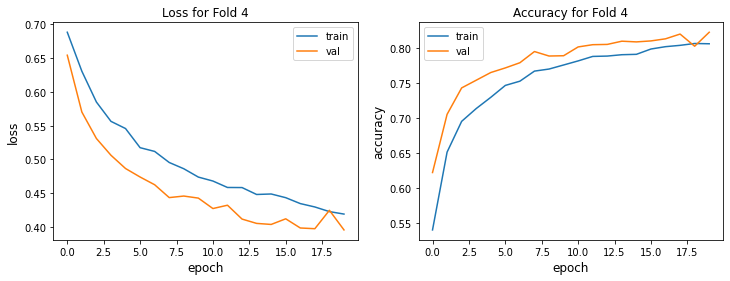

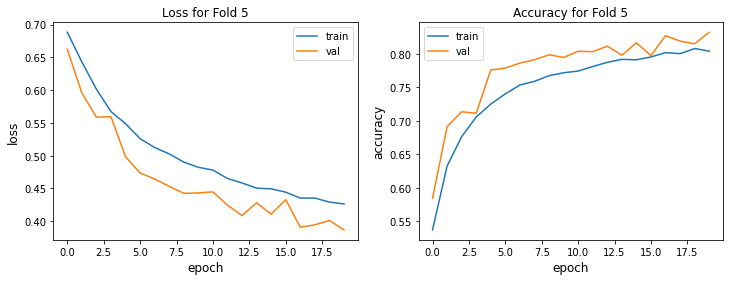

In [ ]:
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tuning_dropout[i+5].history['loss'])
    plt.plot(history_tuning_dropout[i+5].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_tuning_dropout[i+5].history['accuracy'])
    plt.plot(history_tuning_dropout[i+5].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_tuning_dropout)):
    np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/tuning_dropout_cnn_{}.npy'.format(i+6),history_tuning_dropout[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_dropout_model_2.h5")

In [ ]:
for i in range(len(history_tuning_dropout)):
  history_tuning_dropout[i] = history_tuning_dropout[i].history

for i in range(5):
  history = np.load('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/initial_histories_cnn_{}.npy'.format(i+1),allow_pickle='TRUE').item()
  history_tuning_dropout.append(history)

In [ ]:
sum_of_2 = 0
sum_of_5 = 0
sum_of_8 = 0

for i in range(len(history_tuning_dropout)):
  if i < 5:         # dropout = 0.2
    sum_of_2 += history_tuning_dropout[i]['val_accuracy'][-1]
  elif 5 <= i < 10: # dropout = 0.8
    sum_of_8 += history_tuning_dropout[i]['val_accuracy'][-1]
  else:             # dropout = 0.5
    sum_of_5 += history_tuning_dropout[i]['val_accuracy'][-1]

sum_of_2 /= 5
sum_of_5 /= 5
sum_of_8 /= 5

tuned_dropout_list = {
    'dropout: 0.2': sum_of_2,
    'dropout: 0.5': sum_of_5,
    'dropout: 0.8': sum_of_8
}

In [ ]:
print('List in descending order:')
for score in sorted(tuned_dropout_list.items(), key=operator.itemgetter(1), reverse=True):
  print('{:.4f} --> {}'.format(score[1], score[0]))

List in descending order:
0.8352 --> dropout: 0.5
0.8216 --> dropout: 0.8
0.8146 --> dropout: 0.2


#### Increasing the number of epoch again

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/UNIMI/ML/Final Project/models/tuning_dropout_model_2.h5")

In [ ]:
fold_no = 1
history_re_tuning_epoch_dropout = []

for train, test in kfold.split(images, labels):
  
  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      initial_epoch=20,
                      epochs=40,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_re_tuning_epoch_dropout.append(history)

  fold_no = fold_no + 1
  break

Epoch 21/40
167/167 [==============================] - 4s 22ms/step - loss: 0.4320 - accuracy: 0.8055 - val_loss: 0.3682 - val_accuracy: 0.8340
Epoch 22/40
167/167 [==============================] - 3s 19ms/step - loss: 0.4198 - accuracy: 0.8101 - val_loss: 0.3713 - val_accuracy: 0.8252
Epoch 23/40
167/167 [==============================] - 4s 23ms/step - loss: 0.4127 - accuracy: 0.8135 - val_loss: 0.3604 - val_accuracy: 0.8474
Epoch 24/40
167/167 [==============================] - 4s 27ms/step - loss: 0.4175 - accuracy: 0.8105 - val_loss: 0.3581 - val_accuracy: 0.8454
Epoch 25/40
167/167 [==============================] - 3s 19ms/step - loss: 0.4047 - accuracy: 0.8224 - val_loss: 0.3588 - val_accuracy: 0.8422
Epoch 26/40
167/167 [==============================] - 3s 17ms/step - loss: 0.4066 - accuracy: 0.8163 - val_loss: 0.3532 - val_accuracy: 0.8480
Epoch 27/40
167/167 [==============================] - 3s 17ms/step - loss: 0.4022 - accuracy: 0.8152 - val_loss: 0.3543 - val_accuracy:

In [ ]:
new_history_dropout = {}
new_history_dropout = history_tuning_dropout[9]

new_history_dropout['loss'] += history_re_tuning_epoch_dropout[0].history['loss']
new_history_dropout['val_loss'] += history_re_tuning_epoch_dropout[0].history['val_loss']
new_history_dropout['accuracy'] += history_re_tuning_epoch_dropout[0].history['accuracy']
new_history_dropout['val_accuracy'] += history_re_tuning_epoch_dropout[0].history['val_accuracy']

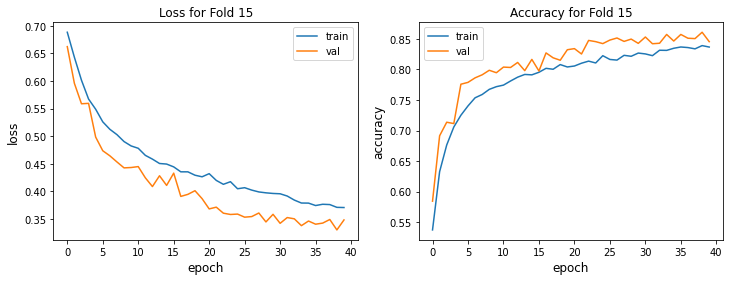

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(new_history_dropout['loss'])
plt.plot(new_history_dropout['val_loss'])
plt.ylabel('loss', size=12)
plt.xlabel('epoch', size=12)
plt.title('Loss for Fold {}'.format(5))
plt.legend(['train', 'val'], fontsize=10)
    
plt.subplot(1, 2, 2)
plt.plot(new_history_dropout['accuracy'])
plt.plot(new_history_dropout['val_accuracy'])
plt.ylabel('accuracy', size=12)
plt.xlabel('epoch', size=12)
plt.title('Accuracy for Fold {}'.format(5))
plt.legend(['train', 'val'], fontsize=10)
plt.show()

#### Running the final model

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
BATCH_SIZE = 120
EPOCHS = 40

In [ ]:
fold_no = 1
history_final_cnn = []

for train, test in kfold.split(images, labels):
  model = convolutional_model(dropout=0.8)

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(images[train], labels[train],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(images[test], labels[test]),
                      verbose=1
                      )
  
  print()
  scores = model.evaluate(images[test], labels[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  history_final_cnn.append(history)

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
167/167 [==============================] - 17s 24ms/step - loss: 0.6756 - accuracy: 0.5696 - val_loss: 0.6131 - val_accuracy: 0.6636
Epoch 2/40
167/167 [==============================] - 3s 17ms/step - loss: 0.6146 - accuracy: 0.6638 - val_loss: 0.5665 - val_accuracy: 0.7068
Epoch 3/40
167/167 [==============================] - 3s 17ms/step - loss: 0.5924 - accuracy: 0.6865 - val_loss: 0.5409 - val_accuracy: 0.7214
Epoch 4/40
167/167 [==============================] - 4s 25ms/step - loss: 0.5607 - accuracy: 0.7130 - val_loss: 0.5112 - val_accuracy: 0.7416
Epoch 5/40
167/167 [==============================] - 3s 18ms/step - loss: 0.5460 - accuracy: 0.7252 - val_loss: 0.4894 - val_accuracy: 0.7644
Epoch 6/40
167/167 [==============================] - 3s 16ms/step - loss: 0.5356 - accuracy: 0.7336 - val_loss: 0.4882 - val_accuracy: 0.7684
Epoch 7/40
167/167 [========================

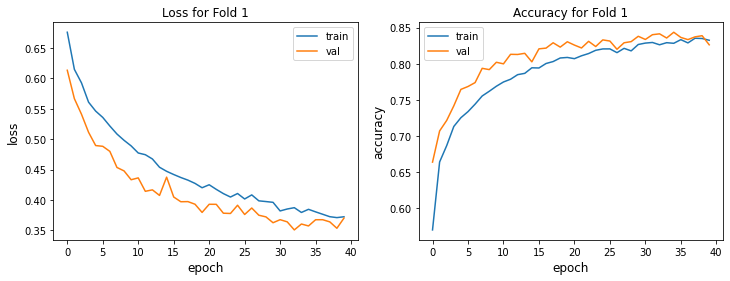

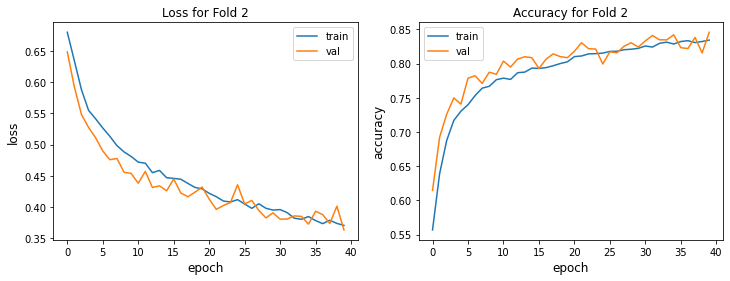

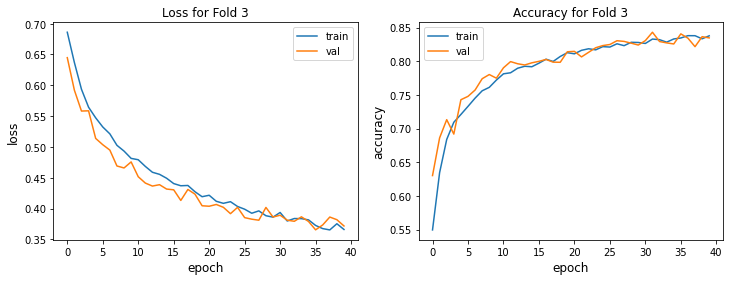

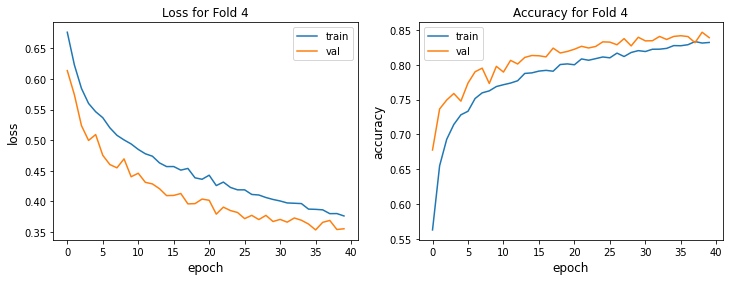

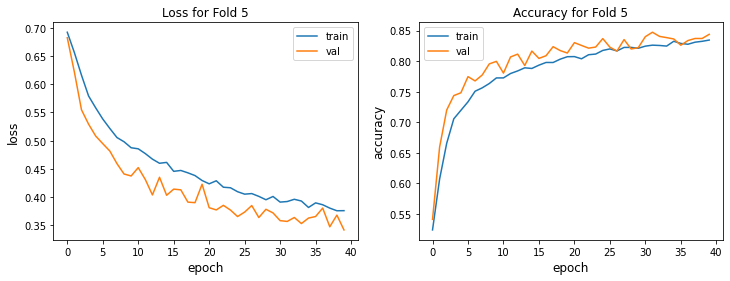

In [ ]:
for i in range(len(history_final_cnn)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_final_cnn[i].history['loss'])
    plt.plot(history_final_cnn[i].history['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Loss for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_final_cnn[i].history['accuracy'])
    plt.plot(history_final_cnn[i].history['val_accuracy'])
    plt.ylabel('accuracy', size=12)
    plt.xlabel('epoch', size=12)
    plt.title('Accuracy for Fold {}'.format(i+1))
    plt.legend(['train', 'val'], fontsize=10)
    plt.show()

In [ ]:
# saving the histories of data to not run neural networks over and over again each time
for i in range(len(history_final_cnn)):
  np.save('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/final_cnn_{}.npy'.format(i+1),history_final_cnn[i].history)

In [ ]:
model.save("/content/drive/MyDrive/UNIMI/ML/Final Project/models/final_cnn_model.h5")

In [ ]:
for i in range(len(history_final_cnn)):
  history_final_cnn[i] = history_final_cnn[i].history

for i in range(5):
  history = np.load('/content/drive/MyDrive/UNIMI/ML/Final Project/histories/initial_histories_cnn_{}.npy'.format(i+1),allow_pickle='TRUE').item()
  history_final_cnn.append(history)

In [ ]:
sum_of_20 = 0
sum_of_40 = 0

for i in range(len(history_final_cnn)):
  if i < 5:         # epochs = 40
    sum_of_40 += history_final_cnn[i]['val_accuracy'][-1]
  else:             # epochs = 20
    sum_of_20 += history_final_cnn[i]['val_accuracy'][-1]

sum_of_20 /= 5
sum_of_40 /= 5

tuned_epochs_list = {
    'epochs: 40': sum_of_40,
    'epochs: 20': sum_of_20
}

In [ ]:
print('List in descending order:')
for score in sorted(tuned_epochs_list.items(), key=operator.itemgetter(1), reverse=True):
  print('{:.4f} --> {}'.format(score[1], score[0]))

List in descending order:
0.8379 --> epochs: 40
0.8352 --> epochs: 20
